# 1.기본설정

In [ ]:
# 데이터 시각화에 사용할 라이브러리
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from tqdm import tqdm
import time

# 데이터 전처리 위한 라이브러리
import numpy as np
import numba
import pandas as pd

# Label Encoding을 위한 라이브러리 불러오기
from sklearn.preprocessing import LabelEncoder

# 최적 파라미터 찾기 위한 라이브러리
import optuna
from optuna.samplers import TPESampler
optuna.logging.disable_default_handler()

# 모델 Vaildation 찾기위한 라이브러리
from sklearn.model_selection import cross_val_score, KFold

# 모델 평가
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 모델링 결과 확인 위한 라이브러리
import shap

# version 확인
import skimage
skimage.__version__

# 그래프를 노트북 안에 그리기 위해 설정
%matplotlib inline

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False
sns.set_theme(style='whitegrid')

plt.style.use('fivethirtyeight')
plt.ion()

import warnings
warnings.filterwarnings('ignore')

##### 한글 깨짐 방지 위한 준비

In [2]:
print ('버전: ', mpl.__version__)
print ('설치 위치: ', mpl.__file__)
print ('설정 위치: ', mpl.get_configdir())
print ('캐시 위치: ', mpl.get_cachedir())
print ('설정파일 위치: ', mpl.matplotlib_fname())

font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')

# ttf 폰트 전체갯수
print(len(font_list)) 

# 시스템 폰트에서 읽어온 리스트에서 상위 10개만 출력
font_list[:10] 

f = [f.name for f in fm.fontManager.ttflist]
print(len(font_list))
# 10개의 폰트명 만 출력
f[:10]

[(f.name, f.fname) for f in fm.fontManager.ttflist if 'Nanum' in f.name]

# size, family
print('# 설정 되어있는 폰트 사이즈')
print (plt.rcParams['font.size'] ) 
print('# 설정 되어있는 폰트 글꼴')
print (plt.rcParams['font.family'] )

# serif, sans-serif, monospace
print('serif 세리프가 있는 폰트--------')
print (plt.rcParams['font.serif']) 
print('sans-serif 세리프가 없는 폰트 --------')
print (plt.rcParams['font.sans-serif']) 
print('monospace 고정폭 글꼴--------')
print (plt.rcParams['font.monospace']) 

plt.rcParams["font.family"] = 'NanumGothic'
plt.rcParams["font.size"] = 20
plt.rcParams["figure.figsize"] = (14,4)

import os

new_directory = 'C:/python'

# 작업 디렉토리 변경
os.chdir(new_directory)

버전:  3.7.1
설치 위치:  C:\Users\user\anaconda3\Lib\site-packages\matplotlib\__init__.py
설정 위치:  C:\Users\user\.matplotlib
캐시 위치:  C:\Users\user\.matplotlib
설정파일 위치:  C:\Users\user\anaconda3\Lib\site-packages\matplotlib\mpl-data\matplotlibrc
381
381
# 설정 되어있는 폰트 사이즈
14.0
# 설정 되어있는 폰트 글꼴
['sans-serif']
serif 세리프가 있는 폰트--------
['DejaVu Serif', 'Bitstream Vera Serif', 'Computer Modern Roman', 'New Century Schoolbook', 'Century Schoolbook L', 'Utopia', 'ITC Bookman', 'Bookman', 'Nimbus Roman No9 L', 'Times New Roman', 'Times', 'Palatino', 'Charter', 'serif']
sans-serif 세리프가 없는 폰트 --------
['Arial', 'DejaVu Sans', 'Liberation Sans', 'Bitstream Vera Sans', 'sans-serif']
monospace 고정폭 글꼴--------
['DejaVu Sans Mono', 'Bitstream Vera Sans Mono', 'Computer Modern Typewriter', 'Andale Mono', 'Nimbus Mono L', 'Courier New', 'Courier', 'Fixed', 'Terminal', 'monospace']


Global Variables

In [3]:
import easydict
args = easydict.EasyDict()

# path 정보
args.default_path = 'Budongsan/new_data/'

# merge 데이터(apt)
args.final_master = args.default_path+'final_master.csv'
args.apt_master = args.default_path+'apt_master_20230730.csv'
# 데이터 분석을 위한 변수들
args.random_state = 42
args.results = []

# 2. 데이터 불러오기

Load merge data

In [4]:
### 사업체 현황 법정동 관련 문제 해결 후 merge 수행
ori_total = pd.read_csv(args.apt_master)
ori_total_s = pd.read_csv(args.final_master)

ori_total['거래금액(만원)'] = ori_total['거래금액(만원)'].str.replace(',','').astype(int)

ori_total_s = ori_total_s[['단지명', '전용면적(㎡)', '계약일', '거래금액(만원)', '층', '건축년도', '자치구', '법정동', '연도', '월', '건설업', '공공 행정, 국방 및 사회보장 행정', '광업', '교육 서비스업', '금융 및 보험업', '농업, 임업 및 어업', '도매 및 소매업', '보건업 및 사회복지 서비스업', '부동산업', '사업시설 관리, 사업 지원 및 임대 서비스업', '수도, 하수 및 폐기물 처리, 원료 재생업', '숙박 및 음식점업', '예술, 스포츠 및 여가관련 서비스업', '운수 및 창고업', '전기, 가스, 증기 및 공기 조절 공급업', '전문, 과학 및 기술 서비스업', '정보통신업', '제조업', '협회 및 단체, 수리 및 기타 개인 서비스업']]

ori_total_main = pd.merge(ori_total, ori_total_s, left_on=['단지명', '전용면적(㎡)', '계약일', '거래금액(만원)', '층', '건축년도', '자치구', '법정동', '연도', '월'], right_on=['단지명', '전용면적(㎡)', '계약일', '거래금액(만원)', '층', '건축년도', '자치구', '법정동', '연도', '월'], how='left')

ori_total_main = ori_total_main[~ori_total_main.duplicated(['Unnamed: 0', '시군구', '번지', '본번', '부번', '단지명', '전용면적(㎡)', '시점', '계약일',
       '거래금액(만원)', '층', '건축년도', '도로명_apt', '시', '자치구', '법정동', '연도', '월',
       '도로명주소', '지번주소', 'x', 'y', '자치구_법정동', '법정동코드'])]

ori_total_main = ori_total_main.reset_index(drop=True)

# 3. EDA & Data Preprocessing

## Missing Value 확인

In [5]:
ori_total_main[ori_total_main['건축년도'].isnull()]

Unnamed: 0            시군구  번지    본번   부번        단지명  전용면적(㎡)  \
291277      291277  서울특별시 은평구 수색동  30  30.0  0.0  DMCSKVIEW    84.99   
291278      291278  서울특별시 은평구 수색동  30  30.0  0.0  DMCSKVIEW    84.99   

                시점  계약일  거래금액(만원)  ...  사업시설 관리, 사업 지원 및 임대 서비스업  \
291277  2022-01-01   28    140000  ...                       NaN   
291278  2022-02-01   10    137000  ...                       NaN   

        수도, 하수 및 폐기물 처리, 원료 재생업 숙박 및 음식점업 예술, 스포츠 및 여가관련 서비스업 운수 및 창고업  \
291277                      NaN       NaN                 NaN      NaN   
291278                      NaN       NaN                 NaN      NaN   

       전기, 가스, 증기 및 공기 조절 공급업  전문, 과학 및 기술 서비스업  정보통신업 제조업  \
291277                    NaN               NaN    NaN NaN   
291278                    NaN               NaN    NaN NaN   

       협회 및 단체, 수리 및 기타 개인 서비스업  
291277                      NaN  
291278                      NaN  

[2 rows x 86 columns]

In [6]:
ori_total_main.loc[291277,'건축년도'] = 2021
ori_total_main.loc[291278,'건축년도'] = 2021

In [7]:
# 모든 빈값에 대해 확인 후 0 대입 - 없는 값이 맞음
ori_total_main = ori_total_main.fillna(0)

## Feature 생성

### - 평단가

In [8]:
ori_total_main['평단가'] = (ori_total_main['거래금액(만원)'] / ori_total_main['전용면적(㎡)']) * 3.3 

### - ㎡당_평균가격

In [9]:
ori_total_main['㎡당_평균가격'] = ori_total_main['거래금액(만원)'] / ori_total_main['전용면적(㎡)']

### - 연식

In [10]:
ori_total_main['연식'] =  ori_total_main['연도'] - ori_total_main['건축년도']

### 재건축 가능 여부

In [11]:
ori_total_main['재건축 가능 여부'] = ori_total_main['연식'].apply(lambda x: 1 if x >= 30 else 0)

### - 아파트 브랜드별 column 생성 & 브랜드 여부

In [12]:
ori_total_main.loc[ori_total_main['단지명'].str.contains('힐스테이트'), '힐스테이트'] = 1
ori_total_main.loc[ori_total_main['단지명'].str.contains('푸르지오'), '푸르지오'] = 1
ori_total_main.loc[ori_total_main['단지명'].str.contains('더샵'), '더샵'] = 1
ori_total_main.loc[ori_total_main['단지명'].str.contains('e편한세상'), 'e편한세상'] = 1
ori_total_main.loc[ori_total_main['단지명'].str.contains('e-편한세상'), 'e편한세상'] = 1
ori_total_main.loc[ori_total_main['단지명'].str.contains('이편한세상'), 'e편한세상'] = 1
ori_total_main.loc[ori_total_main['단지명'].str.contains('이-편한세상'), 'e편한세상'] = 1
ori_total_main.loc[ori_total_main['단지명'].str.contains('위브'), '위브'] = 1
ori_total_main.loc[ori_total_main['단지명'].str.contains('자이'), '자이'] = 1

In [13]:
col=['힐스테이트', '푸르지오', '더샵', 'e편한세상', '위브', '자이']

for i in tqdm(col):
    ori_total_main[i]=ori_total_main[i].fillna(0)

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 170.56it/s]


In [14]:
# 표준편차가 10000 이상으로 차이나는 아파트들만 1로 인식하는 새로운 컬럼 생성

indices = ori_total_main[ori_total_main['단지명'].str.contains('힐스테이트|푸르지오|더샵|e편한세상|e-편한세상|이편한세상|이-편한세상|위브|자이')].index
ori_total_main.loc[indices, '브랜드여부'] = 1

ori_total_main.브랜드여부=ori_total_main.브랜드여부.fillna(0).astype(int)

## 데이터 정리

In [15]:
ori_total_main.columns

Index(['Unnamed: 0', '시군구', '번지', '본번', '부번', '단지명', '전용면적(㎡)', '시점', '계약일',
       '거래금액(만원)', '층', '건축년도', '도로명_apt', '시', '자치구', '법정동', '연도', '월',
       '도로명주소', '지번주소', 'x', 'y', '자치구_법정동', '법정동코드', '총전입', '총전출', '주민등록인구수',
       '총생활인구수', '정류장 ID', '정류소명', '도로명_bus', '버스정류장수', '버스정류장_거리',
       '버스정류장_소요시간', '역사명', '지하철역 수', '지하철역_거리', '지하철역_소요시간', '도로율', '지역내총생산',
       '월평균소득금액', '기준금리', '소비자물가지수', '전세가율', '전월세전환율', '지가지수', '실거래가격지수',
       '소비심리지수', '음식점 수', '카페 수', '편의점 수', '병원 수', '대형마트 수', '백화점 수',
       '5대범죄(총)', '경제활동인구 (천명)', '피보험자수', '공원수', '공원_거리', '공원_소요시간', '학교명',
       '학교수', '학교_거리', '학교_소요시간', '부동산', '부동산 매매', '부동산정책', '건설업',
       '공공 행정, 국방 및 사회보장 행정', '광업', '교육 서비스업', '금융 및 보험업', '농업, 임업 및 어업',
       '도매 및 소매업', '보건업 및 사회복지 서비스업', '부동산업', '사업시설 관리, 사업 지원 및 임대 서비스업',
       '수도, 하수 및 폐기물 처리, 원료 재생업', '숙박 및 음식점업', '예술, 스포츠 및 여가관련 서비스업',
       '운수 및 창고업', '전기, 가스, 증기 및 공기 조절 공급업', '전문, 과학 및 기술 서비스업', '정보통신업',
       '제조업', '협회 및 단체, 수리 및 기타 개인 서비스업', '평단

In [16]:
ori_total_main.drop(['Unnamed: 0'], axis=1, inplace=True)

In [17]:
ori_total_main.to_csv('C:/python/Budongsan/new_data/real_final_master_data.csv', encoding='utf-8')

### - 자치구_법정동

In [18]:
# LabelEncoder 객체 생성 및 적용
label_encoder = LabelEncoder()
ori_total_main['법정동_Encoded'] = label_encoder.fit_transform(ori_total_main['자치구_법정동'])

ori_total_main['법정동_Encoded']

0           0
1           0
2           0
3           0
4           0
         ... 
292460    335
292461    335
292462    335
292463    335
292464    335
Name: 법정동_Encoded, Length: 292465, dtype: int32

### - 재건축

In [19]:
median_by_dong = ori_total_main.groupby('법정동')['거래금액(만원)'].median()
ori_total_main['동별거래금액중앙값'] = ori_total_main['법정동'].map(median_by_dong)

# '재건축' 컬럼 생성 및 값 할당
ori_total_main['재건축'] = ori_total_main.apply(lambda row: 1 if (row['재건축 가능 여부'] == 1 and row['거래금액(만원)'] > row['동별거래금액중앙값']) else 0, axis=1)

### - 연식(with. 건축년도)

In [22]:
# 정수값을 양수로 변환하는 함수 정의
def make_positive(value):
    if value < 0:
        return -value
    return value

In [23]:
# 특정 열에 있는 모든 값을 양수로 변환
target_column = '층'
ori_total_main[target_column] = ori_total_main[target_column].apply(make_positive)

In [25]:
ori_total_main = ori_total_main[ori_total_main['연식']!=-1]

### - 사업체 현황 정리

In [24]:
business_cols = ['건설업', '공공 행정, 국방 및 사회보장 행정', '광업','교육 서비스업', '금융 및 보험업', '농업, 임업 및 어업', '도매 및 소매업', '보건업 및 사회복지 서비스업',
           '부동산업', '사업시설 관리, 사업 지원 및 임대 서비스업', '수도, 하수 및 폐기물 처리, 원료 재생업',
           '숙박 및 음식점업', '예술, 스포츠 및 여가관련 서비스업', '운수 및 창고업',
           '전기, 가스, 증기 및 공기 조절 공급업', '전문, 과학 및 기술 서비스업', '정보통신업', '제조업',
           '협회 및 단체, 수리 및 기타 개인 서비스업']

ori_total_main['사업체'] = ori_total_main[business_cols].apply(lambda cols : cols.sum(),axis = 1)

#컬럼 제거
print(ori_total_main.shape)
ori_total_main.drop(business_cols, axis =1, inplace =True)

print(ori_total_main.shape)

(292465, 68)
(292465, 49)


In [20]:
ori_total_main.drop(['시군구', '번지', '본번', '부번', '단지명', '시점', '계약일', '자치구', '도로명_apt', '시', '연도', '월', '도로명주소', '지번주소', '자치구_법정동', '법정동코드', '정류장 ID', '정류소명', '도로명_bus', '역사명', '학교명', '버스정류장_소요시간', '지하철역_소요시간', '공원_소요시간', '학교_소요시간', '법정동', '평단가', '재건축 가능 여부', '동별거래금액중앙값'], axis=1, inplace=True)
ori_total_main.head()

전용면적(㎡)  거래금액(만원)  층    건축년도          x          y    총전입      총전출  \
0    79.97    130000  4  1987.0  127.05593  37.476795  961.0  13256.0   
1    79.97    117000  2  1987.0  127.05593  37.476795  961.0  13256.0   
2    79.97    130000  1  1987.0  127.05593  37.476795  961.0  13256.0   
3    79.97    139500  2  1987.0  127.05593  37.476795  961.0  13256.0   
4    54.98    107500  5  1987.0  127.05593  37.476795  961.0  13256.0   

   주민등록인구수         총생활인구수  ...    연식  힐스테이트  푸르지오   더샵  e편한세상   위브   자이  \
0   7800.0  837615.719594  ...  31.0    0.0   0.0  0.0    0.0  0.0  0.0   
1   7800.0  837615.719594  ...  31.0    0.0   0.0  0.0    0.0  0.0  0.0   
2   7800.0  837615.719594  ...  31.0    0.0   0.0  0.0    0.0  0.0  0.0   
3   7800.0  826003.757742  ...  31.0    0.0   0.0  0.0    0.0  0.0  0.0   
4   7800.0  817527.898616  ...  31.0    0.0   0.0  0.0    0.0  0.0  0.0   

   브랜드여부  법정동_Encoded  재건축  
0      0            0    0  
1      0            0    0  
2      0            0    0  
3      0            0    0  
4      0            0    0  

[5 rows x 70 columns]

In [21]:
ori_total_main.drop(['x', 'y', '건축년도'], axis=1, inplace=True)
ori_total_main.head()

전용면적(㎡)  거래금액(만원)  층    총전입      총전출  주민등록인구수         총생활인구수  버스정류장수  \
0    79.97    130000  4  961.0  13256.0   7800.0  837615.719594    80.0   
1    79.97    117000  2  961.0  13256.0   7800.0  837615.719594    80.0   
2    79.97    130000  1  961.0  13256.0   7800.0  837615.719594    80.0   
3    79.97    139500  2  961.0  13256.0   7800.0  826003.757742    80.0   
4    54.98    107500  5  961.0  13256.0   7800.0  817527.898616    80.0   

   버스정류장_거리  지하철역 수  ...    연식  힐스테이트  푸르지오   더샵  e편한세상   위브   자이  브랜드여부  \
0   1.42919     2.0  ...  31.0    0.0   0.0  0.0    0.0  0.0  0.0      0   
1   1.42919     2.0  ...  31.0    0.0   0.0  0.0    0.0  0.0  0.0      0   
2   1.42919     2.0  ...  31.0    0.0   0.0  0.0    0.0  0.0  0.0      0   
3   1.42919     2.0  ...  31.0    0.0   0.0  0.0    0.0  0.0  0.0      0   
4   1.42919     2.0  ...  31.0    0.0   0.0  0.0    0.0  0.0  0.0      0   

   법정동_Encoded  재건축  
0            0    0  
1            0    0  
2            0    0  
3            0    0  
4            0    0  

[5 rows x 67 columns]

#### - 분석 후 추가한 경우

In [26]:
ori_total_main['전용면적_s'] = 0
ori_total_main.loc[ori_total_main['전용면적(㎡)'] < ori_total_main['전용면적(㎡)'].quantile(0.2), '전용면적_s'] = 0
ori_total_main.loc[(ori_total_main['전용면적(㎡)'] >= ori_total_main['전용면적(㎡)'].quantile(0.2)) & (ori_total_main['전용면적(㎡)'] < ori_total_main['전용면적(㎡)'].quantile(0.4)), '전용면적_s'] = 1
ori_total_main.loc[(ori_total_main['전용면적(㎡)'] >= ori_total_main['전용면적(㎡)'].quantile(0.4)) & (ori_total_main['전용면적(㎡)'] < ori_total_main['전용면적(㎡)'].quantile(0.6)), '전용면적_s'] = 2
ori_total_main.loc[(ori_total_main['전용면적(㎡)'] >= ori_total_main['전용면적(㎡)'].quantile(0.6)) & (ori_total_main['전용면적(㎡)'] < ori_total_main['전용면적(㎡)'].quantile(0.8)), '전용면적_s'] = 3
ori_total_main.loc[ori_total_main['전용면적(㎡)'] >= ori_total_main['전용면적(㎡)'].quantile(0.8), '전용면적_s'] = 4

In [27]:
ori_total_main['전용면적(㎡)'].describe() 

count    292396.000000
mean         77.049794
std          31.127495
min          10.020000
25%          59.600000
50%          82.130000
75%          84.968000
max         395.060000
Name: 전용면적(㎡), dtype: float64

### * train_test_split

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
X_tr, X_te = train_test_split(ori_total_main, test_size=0.2, random_state=args.random_state)

X_tr.shape, X_te.shape

((233916, 50), (58480, 50))

In [30]:
train = X_tr.copy() 
test = X_te.copy()

train.shape, test.shape

((233916, 50), (58480, 50))

In [31]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233916 entries, 168990 to 121992
Data columns (total 50 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   전용면적(㎡)      233916 non-null  float64
 1   거래금액(만원)     233916 non-null  int32  
 2   층            233916 non-null  int64  
 3   총전입          233916 non-null  float64
 4   총전출          233916 non-null  float64
 5   주민등록인구수      233916 non-null  float64
 6   총생활인구수       233916 non-null  float64
 7   버스정류장수       233916 non-null  float64
 8   버스정류장_거리     233916 non-null  float64
 9   지하철역 수       233916 non-null  float64
 10  지하철역_거리      233916 non-null  float64
 11  도로율          233916 non-null  float64
 12  지역내총생산       233916 non-null  int64  
 13  월평균소득금액      233916 non-null  int64  
 14  기준금리         233916 non-null  float64
 15  소비자물가지수      233916 non-null  float64
 16  전세가율         233916 non-null  float64
 17  전월세전환율       233916 non-null  float64
 18  지가지수         233916

In [32]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58480 entries, 52856 to 236887
Data columns (total 50 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   전용면적(㎡)      58480 non-null  float64
 1   거래금액(만원)     58480 non-null  int32  
 2   층            58480 non-null  int64  
 3   총전입          58480 non-null  float64
 4   총전출          58480 non-null  float64
 5   주민등록인구수      58480 non-null  float64
 6   총생활인구수       58480 non-null  float64
 7   버스정류장수       58480 non-null  float64
 8   버스정류장_거리     58480 non-null  float64
 9   지하철역 수       58480 non-null  float64
 10  지하철역_거리      58480 non-null  float64
 11  도로율          58480 non-null  float64
 12  지역내총생산       58480 non-null  int64  
 13  월평균소득금액      58480 non-null  int64  
 14  기준금리         58480 non-null  float64
 15  소비자물가지수      58480 non-null  float64
 16  전세가율         58480 non-null  float64
 17  전월세전환율       58480 non-null  float64
 18  지가지수         58480 non-null  float64
 19 

## 다중공선성 확인

In [33]:
# 처음 제거하게 된 경우
train_s = train.drop(columns=['거래금액(만원)','법정동_Encoded','전용면적(㎡)','㎡당_평균가격', '전용면적_s', '재건축'])

In [34]:
# 결과확인하며 지우게되는 경우
train_s = train.drop(columns=['버스정류장수','부동산','버스정류장_거리','총생활인구수','주민등록인구수','소비자물가지수','학교_거리','편의점 수','실거래가격지수','5대범죄(총)','도로율','전세가율','지역내총생산','음식점 수','소비심리지수','전월세전환율','경제활동인구 (천명)','지가지수','거래금액(만원)','법정동_Encoded','전용면적(㎡)','㎡당_평균가격', '전용면적_s', '재건축','브랜드여부','푸르지오', '더샵', 'e편한세상', '위브', '자이','힐스테이트'])

In [35]:
%%time
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF 계산
vif = pd.DataFrame()
vif['Features'] = train_s.columns
vif['VIF'] = [variance_inflation_factor(train_s.values, i) for i in tqdm(range(train_s.shape[1]))]

# # VIF 결과 출력
# vif

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:08<00:00,  2.21it/s]

CPU times: total: 20 s
Wall time: 8.82 s


In [36]:
# 출력 옵션 변경하여 최대 100개 행까지 확인
pd.set_option('display.max_rows', 100)
pd.options.display.float_format = '{:.6f}'.format
vif # 지역내총생산 지가지수 음식점 수 편의점 수 피보험자수 브랜드여부 건축년도 연식

Features       VIF
0         층  3.143539
1       총전입  7.616559
2       총전출 11.217625
3    지하철역 수  5.705778
4   지하철역_거리  4.958564
5   월평균소득금액 14.118005
6      기준금리  4.683463
7      카페 수 17.756973
8      병원 수  4.778423
9    대형마트 수  2.008269
10    백화점 수  1.618808
11    피보험자수  3.346898
12      공원수  2.456598
13    공원_거리  2.980094
14      학교수  6.850116
15   부동산 매매  5.603462
16    부동산정책  1.543716
17       연식  4.805036
18      사업체 14.459137

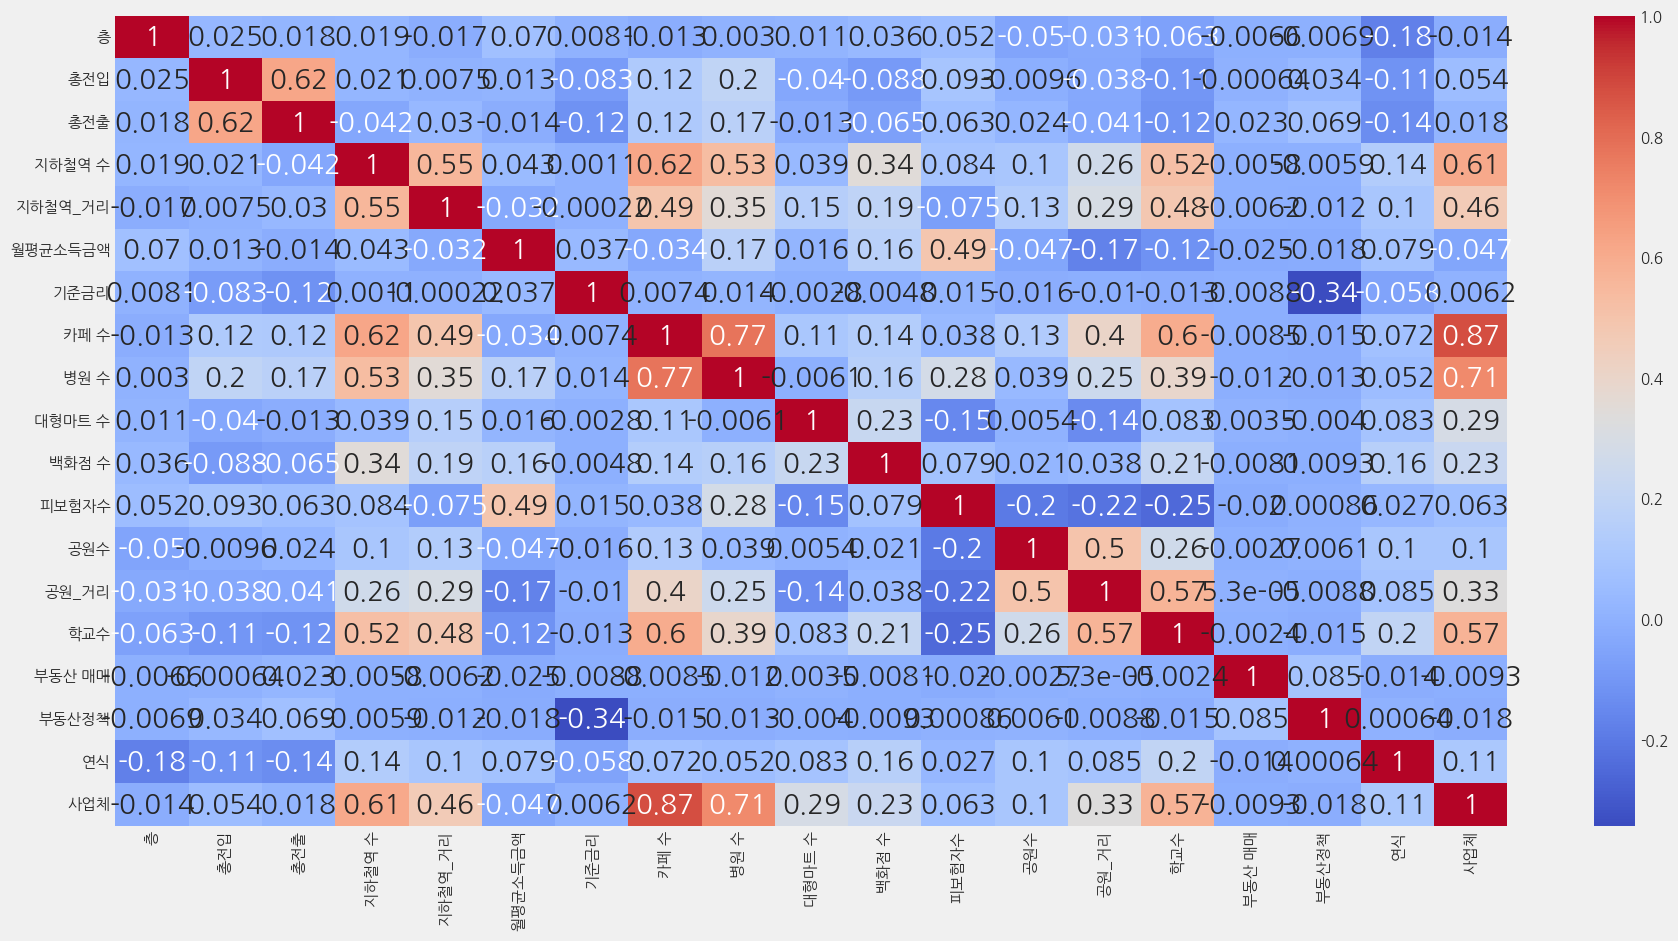

In [37]:
# 상관 행렬 시각화
plt.figure(figsize=(20, 10))
sns.heatmap(train_s.corr(), annot=True, cmap='coolwarm')
plt.show()

In [38]:
# 컬럼 선택
train = train[['거래금액(만원)', '층', '총전입', '총전출', '지하철역 수', '지하철역_거리', '월평균소득금액', '기준금리', '카페 수',
       '병원 수', '대형마트 수', '백화점 수', '피보험자수', '공원수', '공원_거리', '학교수', '부동산 매매',
       '부동산정책', '연식', '사업체', '법정동_Encoded', '전용면적_s', '재건축']]

test = test[['거래금액(만원)', '층', '총전입', '총전출', '지하철역 수', '지하철역_거리', '월평균소득금액', '기준금리', '카페 수',
       '병원 수', '대형마트 수', '백화점 수', '피보험자수', '공원수', '공원_거리', '학교수', '부동산 매매',
       '부동산정책', '연식', '사업체', '법정동_Encoded', '전용면적_s', '재건축']]

## Feature Engineering

In [39]:
import statsmodels.api as sm

### 변수 선택 - 전진 선택법

In [40]:
## 전진 선택법
variables = train.drop(columns='거래금액(만원)').columns.tolist() ## 설명 변수 리스트
 
y = train['거래금액(만원)'] #.values.reshape(-1,1)
selected_variables = [] ## 선택된 변수들
sl_enter = 0.05
 
sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0
while len(variables) > 0:
    remainder = list(set(variables) - set(selected_variables))
    pval = pd.Series(index=remainder) ## 변수의 p-value
    ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 
    ## 선형 모형을 적합한다.
    for col in tqdm(remainder): 
        X = train[selected_variables+[col]]
        X = sm.add_constant(X)
        model = sm.OLS(y,X).fit()
        pval[col] = model.pvalues[col]
 
    min_pval = pval.min()
    if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
        selected_variables.append(pval.idxmin())
        
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y,sm.add_constant(train[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.78it/s]


In [41]:
len(selected_variables)

21

In [42]:
selected_variables

['층',
 '백화점 수',
 '피보험자수',
 '재건축',
 '학교수',
 '연식',
 '사업체',
 '카페 수',
 '병원 수',
 '전용면적_s',
 '기준금리',
 '월평균소득금액',
 '대형마트 수',
 '지하철역 수',
 '공원_거리',
 '부동산정책',
 '법정동_Encoded',
 '부동산 매매',
 '총전입',
 '공원수',
 '총전출']

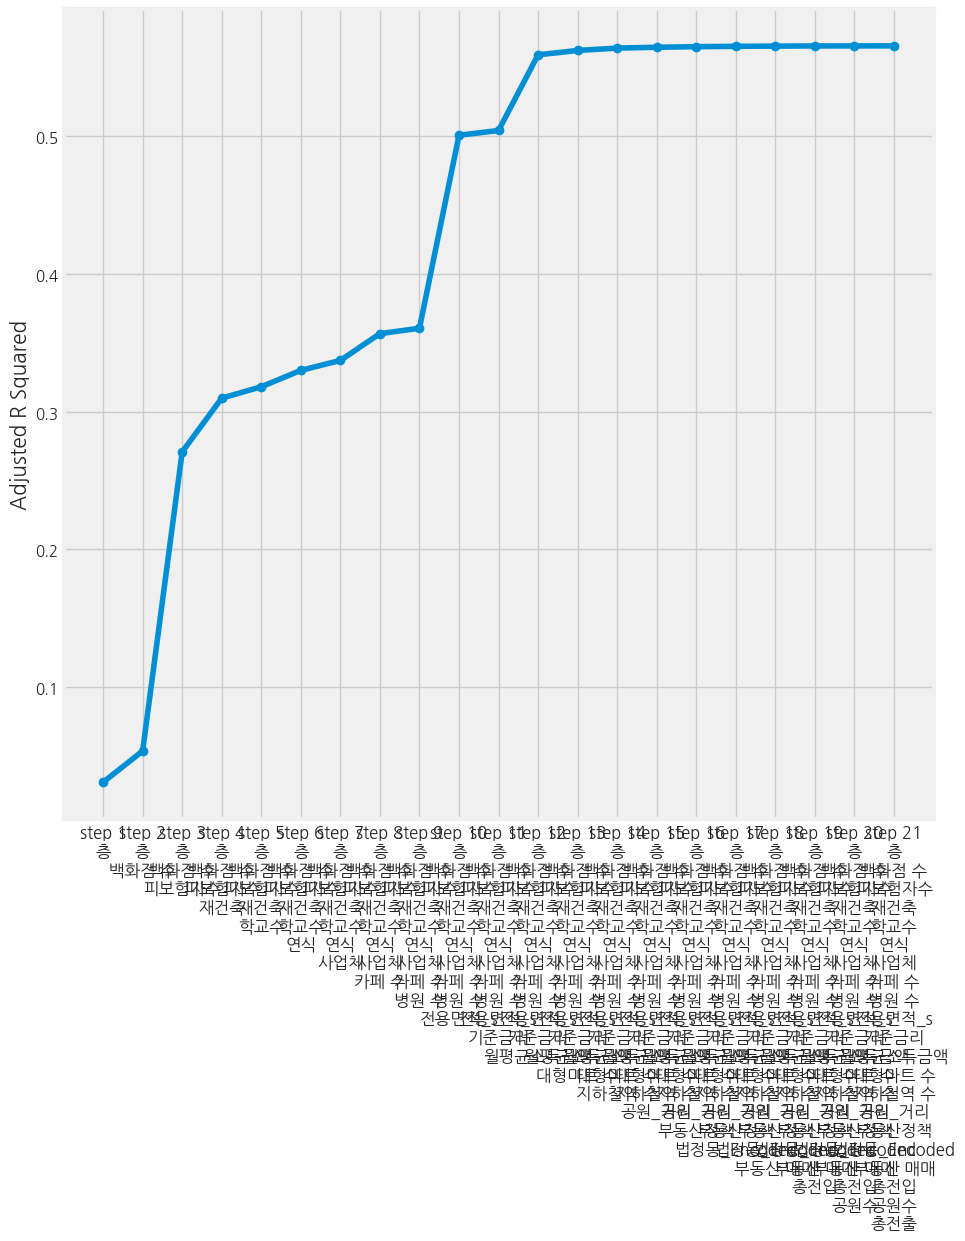

In [43]:
# 결과 확인 시각화
fig = plt.figure(figsize=(10,10))
fig.set_facecolor('white')
 
font_size = 15
plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12)
plt.plot(steps,adjusted_r_squared, marker='o')
    
plt.ylabel('Adjusted R Squared',fontsize=font_size)
plt.grid(True)
plt.show()

### 변수 선택 - 후진 선택법

In [44]:
## 후진 소거법
variables = train.drop(columns='거래금액(만원)').columns.tolist() ## 설명 변수 리스트
 
y = train['거래금액(만원)'] ## 반응 변수
selected_variables = variables ## 초기에는 모든 변수가 선택된 상태
sl_remove = 0.05
 
sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0
while len(selected_variables) > 0:
    X = sm.add_constant(train[selected_variables])
    p_vals = sm.OLS(y,X).fit().pvalues[1:] ## 절편항의 p-value는 뺀다
    max_pval = p_vals.max() ## 최대 p-value
    if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
        remove_variable = p_vals.idxmax()
        selected_variables.remove(remove_variable)
 
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y,sm.add_constant(train[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break

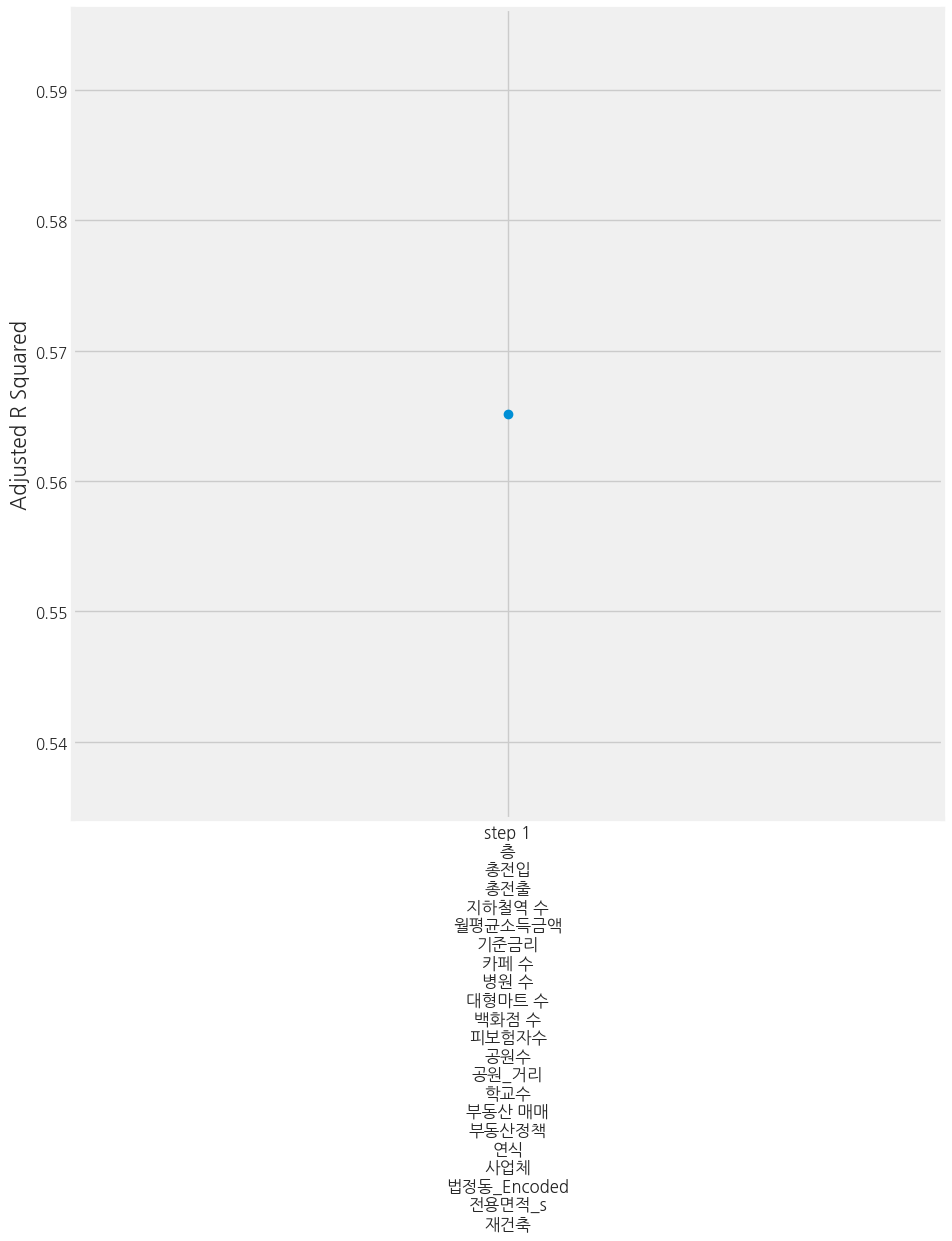

In [45]:
# 결과 시각화
fig = plt.figure(figsize=(10,10))
fig.set_facecolor('white')
 
font_size = 15
plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12)
plt.plot(steps,adjusted_r_squared, marker='o')
    
plt.ylabel('Adjusted R Squared',fontsize=font_size)
plt.grid(True)
plt.show()

In [46]:
len(selected_variables)

21

### 변수 선택 - Stepwise 

In [47]:
%%time
## 전진 단계별 선택법
variables = train.drop(columns='거래금액(만원)').columns.tolist() ## 설명 변수 리스트
 
y = train['거래금액(만원)'] ## 반응 변수
selected_variables = [] ## 선택된 변수들
sl_enter = 0.05
sl_remove = 0.05
 
sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0
while len(variables) > 0:
    remainder = list(set(variables) - set(selected_variables))
    pval = pd.Series(index=remainder) ## 변수의 p-value
    ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 
    ## 선형 모형을 적합한다.
    for col in tqdm(remainder): 
        X = train[selected_variables+[col]]
        X = sm.add_constant(X)
        model = sm.OLS(y,X).fit()
        pval[col] = model.pvalues[col]
 
    min_pval = pval.min()
    if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
        selected_variables.append(pval.idxmin())
        ## 선택된 변수들에대해서
        ## 어떤 변수를 제거할지 고른다.
        while len(selected_variables) > 0:
            selected_X = train[selected_variables]
            selected_X = sm.add_constant(selected_X)
            selected_pval = sm.OLS(y,selected_X).fit().pvalues[1:] ## 절편항의 p-value는 뺀다
            max_pval = selected_pval.max()
            if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
                remove_variable = selected_pval.idxmax()
                selected_variables.remove(remove_variable)
            else:
                break
        
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y,sm.add_constant(train[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.76it/s]

CPU times: total: 2min 5s
Wall time: 1min


In [48]:
selected_variables

['층',
 '백화점 수',
 '피보험자수',
 '재건축',
 '학교수',
 '연식',
 '사업체',
 '카페 수',
 '병원 수',
 '전용면적_s',
 '기준금리',
 '월평균소득금액',
 '대형마트 수',
 '지하철역 수',
 '공원_거리',
 '부동산정책',
 '법정동_Encoded',
 '부동산 매매',
 '총전입',
 '공원수',
 '총전출']

In [49]:
len(selected_variables)

21

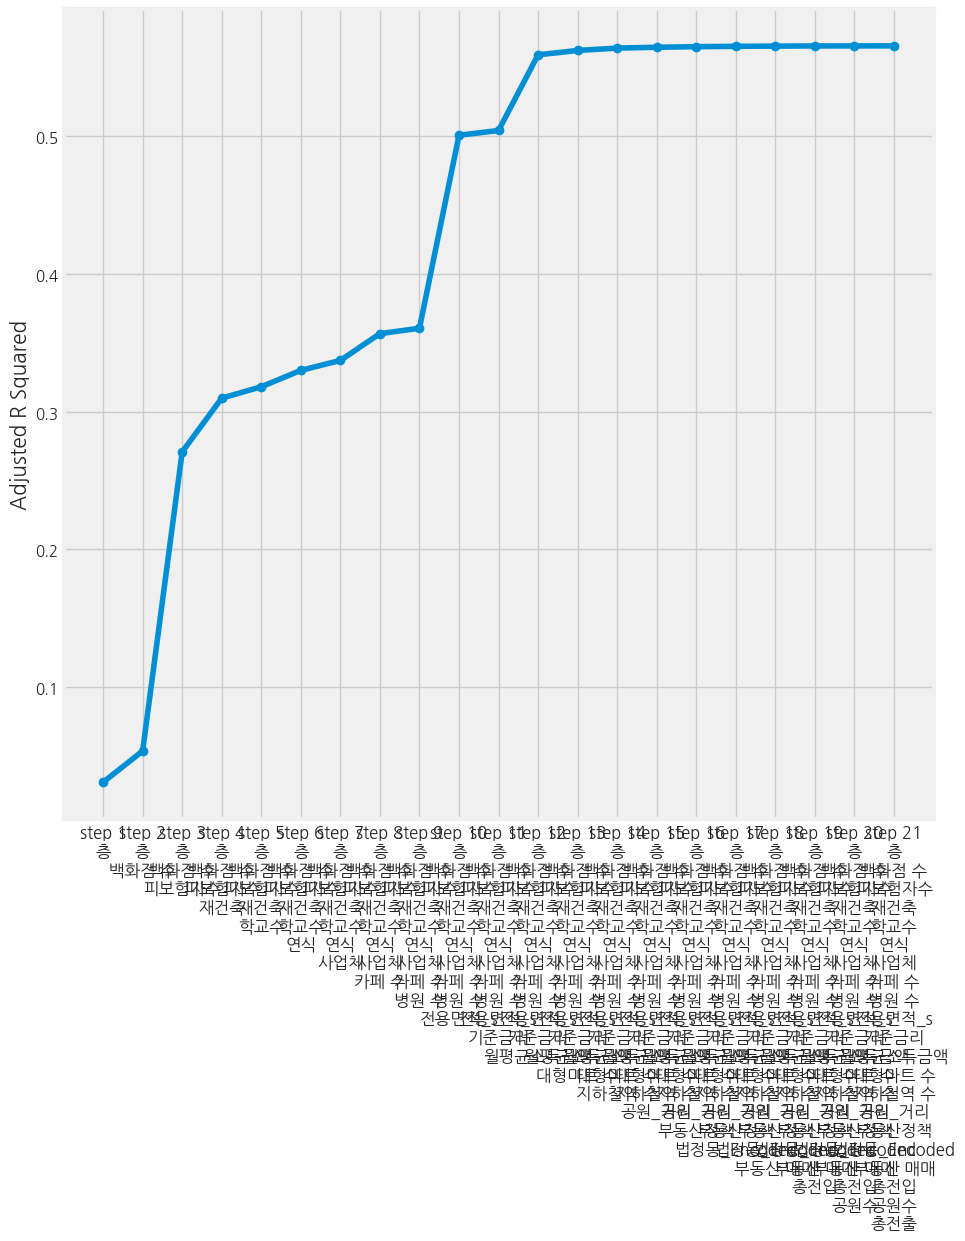

In [50]:
# 결과 확인 시각화
fig = plt.figure(figsize=(10,10))
fig.set_facecolor('white')
 
font_size = 15
plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12)
plt.plot(steps,adjusted_r_squared, marker='o')
    
plt.ylabel('Adjusted R Squared',fontsize=font_size)
plt.grid(True)
plt.show()

In [51]:
# 변수 최종 선택
train = train[['거래금액(만원)', '백화점 수', '공원수', '사업체', '전용면적_s', '학교수', '월평균소득금액', '재건축', '연식', '지하철역 수', '병원 수',
               '기준금리', '층', '피보험자수', '카페 수', '대형마트 수', '부동산정책', '법정동_Encoded', '공원_거리', '부동산 매매', '총전입', '총전출']]

test = test[['거래금액(만원)', '백화점 수', '공원수', '사업체', '전용면적_s', '학교수', '월평균소득금액', '재건축', '연식', '지하철역 수', '병원 수',
               '기준금리', '층', '피보험자수', '카페 수', '대형마트 수', '부동산정책', '법정동_Encoded', '공원_거리', '부동산 매매', '총전입', '총전출']]

# 4. Data Encoding & Scaling

## 원본

In [52]:
y_tr = train['거래금액(만원)']
X_tr = train.drop(['거래금액(만원)'], axis=1)

y_te = test['거래금액(만원)']
X_te = test.drop(['거래금액(만원)'], axis=1)

X_tr.shape, y_tr.shape, X_te.shape, y_te.shape

((233916, 21), (233916,), (58480, 21), (58480,))

In [53]:
X_tr.columns

Index(['백화점 수', '공원수', '사업체', '전용면적_s', '학교수', '월평균소득금액', '재건축', '연식',
       '지하철역 수', '병원 수', '기준금리', '층', '피보험자수', '카페 수', '대형마트 수', '부동산정책',
       '법정동_Encoded', '공원_거리', '부동산 매매', '총전입', '총전출'],
      dtype='object')

### 명목형 데이터 Encoding

In [56]:
from sklearn.preprocessing import OneHotEncoder

In [55]:
X_tr = X_tr.astype({'전용면적_s': str})
X_te = X_te.astype({'전용면적_s': str})

In [57]:
X_tr.columns

Index(['백화점 수', '공원수', '사업체', '전용면적_s', '학교수', '월평균소득금액', '재건축', '연식',
       '지하철역 수', '병원 수', '기준금리', '층', '피보험자수', '카페 수', '대형마트 수', '부동산정책',
       '법정동_Encoded', '공원_거리', '부동산 매매', '총전입', '총전출'],
      dtype='object')

In [58]:
enc_cols = ['전용면적_s']
normal_cols = list(set(X_tr.columns) - set(enc_cols))
normal_cols

['카페 수',
 '층',
 '백화점 수',
 '지하철역 수',
 '피보험자수',
 '학교수',
 '재건축',
 '공원_거리',
 '월평균소득금액',
 '공원수',
 '법정동_Encoded',
 '부동산 매매',
 '총전입',
 '연식',
 '총전출',
 '사업체',
 '대형마트 수',
 '기준금리',
 '병원 수',
 '부동산정책']

In [59]:
enc_cols = list(X_tr.select_dtypes(exclude=np.number).columns)
print(f'len_enc_cols: {len(enc_cols)}')
encoder = OneHotEncoder() 
enc_dfs = []

for i, df in enumerate([X_tr, X_te]):
  if not i:
    _encoded = encoder.fit_transform(df[enc_cols])
  else:
    _encoded = encoder.transform(df[enc_cols])

  _encoded_df = pd.DataFrame(
    _encoded.toarray(), 
    columns = encoder.get_feature_names_out()
  )

  not_enc_cols = list(set(df.columns) - set(enc_cols))
  enc_dfs.append(
    pd.concat(
      [df[not_enc_cols].reset_index(drop=True), _encoded_df.reset_index(drop=True)]
      , axis=1
    ).reset_index(drop=True)
  )

X_tr = enc_dfs[0]
X_te = enc_dfs[1]

print(f'{X_tr.isnull().sum().sum()} / {X_te.isnull().sum().sum()}')
X_tr.shape, X_te.shape

len_enc_cols: 1
0 / 0


((233916, 25), (58480, 25))

Column 정리

In [60]:
print(f'before: {X_tr.shape} / {X_te.shape} / {y_tr.shape} / {y_te.shape}')

print(f'after: {X_tr.shape} / {X_te.shape}/ {y_tr.shape} / {y_te.shape}')
X_tr.info()

before: (233916, 25) / (58480, 25) / (233916,) / (58480,)
after: (233916, 25) / (58480, 25)/ (233916,) / (58480,)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233916 entries, 0 to 233915
Data columns (total 25 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   카페 수         233916 non-null  int64  
 1   층            233916 non-null  int64  
 2   백화점 수        233916 non-null  int64  
 3   지하철역 수       233916 non-null  float64
 4   피보험자수        233916 non-null  int64  
 5   학교수          233916 non-null  float64
 6   재건축          233916 non-null  int64  
 7   공원_거리        233916 non-null  float64
 8   월평균소득금액      233916 non-null  int64  
 9   공원수          233916 non-null  float64
 10  법정동_Encoded  233916 non-null  int32  
 11  부동산 매매       233916 non-null  float64
 12  총전입          233916 non-null  float64
 13  연식           233916 non-null  float64
 14  총전출          233916 non-null  float64
 15  사업체          233916 non-null  float64
 

## StandardScaler case

In [70]:
from sklearn.preprocessing import StandardScaler

In [61]:
y_tr_sd = train['거래금액(만원)']
X_tr_sd = train.drop(['거래금액(만원)'], axis=1)

y_te_sd = test['거래금액(만원)']
X_te_sd = test.drop(['거래금액(만원)'], axis=1)

X_tr_sd.shape, y_tr_sd.shape, X_te_sd.shape, y_te_sd.shape

((233916, 21), (233916,), (58480, 21), (58480,))

### 명목형 데이터 Encoding

In [62]:
X_tr_sd = X_tr_sd.astype({'전용면적_s': str})
X_te_sd = X_te_sd.astype({'전용면적_s': str})

In [64]:
X_tr_sd.columns

Index(['백화점 수', '공원수', '사업체', '전용면적_s', '학교수', '월평균소득금액', '재건축', '연식',
       '지하철역 수', '병원 수', '기준금리', '층', '피보험자수', '카페 수', '대형마트 수', '부동산정책',
       '법정동_Encoded', '공원_거리', '부동산 매매', '총전입', '총전출'],
      dtype='object')

In [65]:
enc_cols = ['전용면적_s']
normal_cols = list(set(X_tr_sd.columns) - set(enc_cols))
normal_cols

['카페 수',
 '층',
 '백화점 수',
 '지하철역 수',
 '피보험자수',
 '학교수',
 '재건축',
 '공원_거리',
 '월평균소득금액',
 '공원수',
 '법정동_Encoded',
 '부동산 매매',
 '총전입',
 '연식',
 '총전출',
 '사업체',
 '대형마트 수',
 '기준금리',
 '병원 수',
 '부동산정책']

In [66]:
enc_cols = list(X_tr_sd.select_dtypes(exclude=np.number).columns)
print(f'len_enc_cols: {len(enc_cols)}')
encoder = OneHotEncoder() 
enc_dfs = []

for i, df in enumerate([X_tr_sd, X_te_sd]):
  if not i:
    _encoded = encoder.fit_transform(df[enc_cols])
  else:
    _encoded = encoder.transform(df[enc_cols])

  _encoded_df = pd.DataFrame(
    _encoded.toarray(), 
    columns = encoder.get_feature_names_out()
  )

  not_enc_cols = list(set(df.columns) - set(enc_cols))
  enc_dfs.append(
    pd.concat(
      [df[not_enc_cols].reset_index(drop=True), _encoded_df.reset_index(drop=True)]
      , axis=1
    ).reset_index(drop=True)
  )

X_tr_sd = enc_dfs[0]
X_te_sd = enc_dfs[1]

print(f'{X_tr_sd.isnull().sum().sum()} / {X_te_sd.isnull().sum().sum()}')
X_tr_sd.shape, X_te_sd.shape

len_enc_cols: 1
0 / 0


((233916, 25), (58480, 25))

### 수치형 데이터 Scaler

In [67]:
X_tr_sd.isnull().sum().sum(), X_te_sd.isnull().sum().sum()

(0, 0)

In [68]:
X_tr_sd.columns

Index(['카페 수', '층', '백화점 수', '지하철역 수', '피보험자수', '학교수', '재건축', '공원_거리',
       '월평균소득금액', '공원수', '법정동_Encoded', '부동산 매매', '총전입', '연식', '총전출', '사업체',
       '대형마트 수', '기준금리', '병원 수', '부동산정책', '전용면적_s_0', '전용면적_s_1', '전용면적_s_2',
       '전용면적_s_3', '전용면적_s_4'],
      dtype='object')

In [69]:
scaling_cols = ['연식', '백화점 수', '부동산정책', '공원수', '기준금리', '사업체', '학교수', '총전입', '피보험자수',
       '대형마트 수', '병원 수', '총전출', '부동산 매매', '월평균소득금액', '지하철역 수', '층', '공원_거리', '카페 수']
not_scaling_cols = list(set(X_tr_sd.columns) - set(scaling_cols))
not_scaling_cols 

['법정동_Encoded',
 '전용면적_s_0',
 '전용면적_s_3',
 '재건축',
 '전용면적_s_2',
 '전용면적_s_1',
 '전용면적_s_4']

In [71]:
scaler = StandardScaler()

_scaled_tr = scaler.fit_transform(X_tr_sd[scaling_cols])
_scaled_te = scaler.transform(X_te_sd[scaling_cols])

In [72]:
scaling_cols = ['연식', '백화점 수', '부동산정책', '공원수', '기준금리', '사업체', '학교수', '총전입', '피보험자수',
       '대형마트 수', '병원 수', '총전출', '부동산 매매', '월평균소득금액', '지하철역 수', '층', '공원_거리', '카페 수']
scaler = StandardScaler()
scaled_dfs = []

for i, df in enumerate([X_tr_sd, X_te_sd]):
  if not i:
    _scaled = scaler.fit_transform(df[scaling_cols])
  else:
    _scaled = scaler.transform(df[scaling_cols])

  _scaled_df = pd.DataFrame(
    _scaled, 
    columns = scaling_cols
  )

  not_scaling_cols = list(set(df.columns) - set(scaling_cols))

  scaled_dfs.append(
    pd.concat(
      [df[not_scaling_cols].reset_index(drop=True), _scaled_df.reset_index(drop=True)]
      , axis=1
    ).reset_index(drop=True)
  )

X_tr_sd = scaled_dfs[0]
X_te_sd = scaled_dfs[1]

print(f'{X_tr_sd.isnull().sum().sum()} / {X_te_sd.isnull().sum().sum()}')
X_tr_sd.shape, X_te_sd.shape

0 / 0


((233916, 25), (58480, 25))

Column 정리

In [73]:
print(f'before: {X_tr_sd.shape} / {X_te_sd.shape} / {y_tr_sd.shape} / {y_te_sd.shape}')

print(f'after: {X_tr_sd.shape} / {X_te_sd.shape}/ {y_tr_sd.shape} / {y_te_sd.shape}')
X_tr_sd.info()

before: (233916, 25) / (58480, 25) / (233916,) / (58480,)
after: (233916, 25) / (58480, 25)/ (233916,) / (58480,)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233916 entries, 0 to 233915
Data columns (total 25 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   법정동_Encoded  233916 non-null  int32  
 1   전용면적_s_0     233916 non-null  float64
 2   전용면적_s_3     233916 non-null  float64
 3   재건축          233916 non-null  int64  
 4   전용면적_s_2     233916 non-null  float64
 5   전용면적_s_1     233916 non-null  float64
 6   전용면적_s_4     233916 non-null  float64
 7   연식           233916 non-null  float64
 8   백화점 수        233916 non-null  float64
 9   부동산정책        233916 non-null  float64
 10  공원수          233916 non-null  float64
 11  기준금리         233916 non-null  float64
 12  사업체          233916 non-null  float64
 13  학교수          233916 non-null  float64
 14  총전입          233916 non-null  float64
 15  피보험자수        233916 non-null  float64
 

## MinMaxScaler case

In [82]:
from sklearn.preprocessing import MinMaxScaler

In [74]:
y_tr_mm = train['거래금액(만원)']
X_tr_mm = train.drop(['거래금액(만원)'], axis=1)

y_te_mm = test['거래금액(만원)']
X_te_mm = test.drop(['거래금액(만원)'], axis=1)

X_tr_mm.shape, y_tr_mm.shape, X_te_mm.shape, y_te_mm.shape

((233916, 21), (233916,), (58480, 21), (58480,))

### 명목형 데이터 Encoding

In [75]:
X_tr_mm = X_tr_mm.astype({'전용면적_s': str})
X_te_mm = X_te_mm.astype({'전용면적_s': str})

In [76]:
X_tr_mm.columns

Index(['백화점 수', '공원수', '사업체', '전용면적_s', '학교수', '월평균소득금액', '재건축', '연식',
       '지하철역 수', '병원 수', '기준금리', '층', '피보험자수', '카페 수', '대형마트 수', '부동산정책',
       '법정동_Encoded', '공원_거리', '부동산 매매', '총전입', '총전출'],
      dtype='object')

In [77]:
enc_cols = ['전용면적_s']
normal_cols = list(set(X_tr_mm.columns) - set(enc_cols))
normal_cols

['카페 수',
 '층',
 '백화점 수',
 '지하철역 수',
 '피보험자수',
 '학교수',
 '재건축',
 '공원_거리',
 '월평균소득금액',
 '공원수',
 '법정동_Encoded',
 '부동산 매매',
 '총전입',
 '연식',
 '총전출',
 '사업체',
 '대형마트 수',
 '기준금리',
 '병원 수',
 '부동산정책']

In [78]:
enc_cols = list(X_tr_mm.select_dtypes(exclude=np.number).columns)
print(f'len_enc_cols: {len(enc_cols)}')
encoder = OneHotEncoder() 
enc_dfs = []

for i, df in enumerate([X_tr_mm, X_te_mm]):
  if not i:
    _encoded = encoder.fit_transform(df[enc_cols])
  else:
    _encoded = encoder.transform(df[enc_cols])

  _encoded_df = pd.DataFrame(
    _encoded.toarray(), 
    columns = encoder.get_feature_names_out()
  )

  not_enc_cols = list(set(df.columns) - set(enc_cols))
  enc_dfs.append(
    pd.concat(
      [df[not_enc_cols].reset_index(drop=True), _encoded_df.reset_index(drop=True)]
      , axis=1
    ).reset_index(drop=True)
  )

X_tr_mm = enc_dfs[0]
X_te_mm = enc_dfs[1]

print(f'{X_tr_mm.isnull().sum().sum()} / {X_te_mm.isnull().sum().sum()}')
X_tr_mm.shape, X_te_mm.shape

len_enc_cols: 1
0 / 0


((233916, 25), (58480, 25))

### 수치형 데이터 Scaler

In [79]:
X_tr_mm.isnull().sum().sum(), X_te_mm.isnull().sum().sum()

(0, 0)

In [80]:
X_tr_mm.columns

Index(['카페 수', '층', '백화점 수', '지하철역 수', '피보험자수', '학교수', '재건축', '공원_거리',
       '월평균소득금액', '공원수', '법정동_Encoded', '부동산 매매', '총전입', '연식', '총전출', '사업체',
       '대형마트 수', '기준금리', '병원 수', '부동산정책', '전용면적_s_0', '전용면적_s_1', '전용면적_s_2',
       '전용면적_s_3', '전용면적_s_4'],
      dtype='object')

In [81]:
scaling_cols = ['연식', '백화점 수', '부동산정책', '공원수', '기준금리', '사업체', '학교수', '총전입', '피보험자수',
       '대형마트 수', '병원 수', '총전출', '부동산 매매', '월평균소득금액', '지하철역 수', '층', '공원_거리', '카페 수']
not_scaling_cols = list(set(X_tr_mm.columns) - set(scaling_cols))
not_scaling_cols 

['법정동_Encoded',
 '전용면적_s_0',
 '전용면적_s_3',
 '재건축',
 '전용면적_s_2',
 '전용면적_s_1',
 '전용면적_s_4']

In [83]:
scaler = MinMaxScaler()

_scaled_tr = scaler.fit_transform(X_tr_mm[scaling_cols])
_scaled_te = scaler.transform(X_te_mm[scaling_cols])

In [84]:
scaling_cols = ['연식', '백화점 수', '부동산정책', '공원수', '기준금리', '사업체', '학교수', '총전입', '피보험자수',
       '대형마트 수', '병원 수', '총전출', '부동산 매매', '월평균소득금액', '지하철역 수', '층', '공원_거리', '카페 수']
scaler = MinMaxScaler()
scaled_dfs = []

for i, df in enumerate([X_tr_mm, X_te_mm]):
  if not i:
    _scaled = scaler.fit_transform(df[scaling_cols])
  else:
    _scaled = scaler.transform(df[scaling_cols])

  _scaled_df = pd.DataFrame(
    _scaled, 
    columns = scaling_cols
  )

  not_scaling_cols = list(set(df.columns) - set(scaling_cols))

  scaled_dfs.append(
    pd.concat(
      [df[not_scaling_cols].reset_index(drop=True), _scaled_df.reset_index(drop=True)]
      , axis=1
    ).reset_index(drop=True)
  )

X_tr_mm = scaled_dfs[0]
X_te_mm = scaled_dfs[1]

print(f'{X_tr_mm.isnull().sum().sum()} / {X_te_mm.isnull().sum().sum()}')
X_tr_mm.shape, X_te_mm.shape

0 / 0


((233916, 25), (58480, 25))

Column 정리

In [85]:
print(f'before: {X_tr_mm.shape} / {X_te_mm.shape} / {y_tr_mm.shape} / {y_te_mm.shape}')

print(f'after: {X_tr_mm.shape} / {X_te_mm.shape}/ {y_tr_mm.shape} / {y_te_mm.shape}')
X_tr_mm.info()

before: (233916, 25) / (58480, 25) / (233916,) / (58480,)
after: (233916, 25) / (58480, 25)/ (233916,) / (58480,)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233916 entries, 0 to 233915
Data columns (total 25 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   법정동_Encoded  233916 non-null  int32  
 1   전용면적_s_0     233916 non-null  float64
 2   전용면적_s_3     233916 non-null  float64
 3   재건축          233916 non-null  int64  
 4   전용면적_s_2     233916 non-null  float64
 5   전용면적_s_1     233916 non-null  float64
 6   전용면적_s_4     233916 non-null  float64
 7   연식           233916 non-null  float64
 8   백화점 수        233916 non-null  float64
 9   부동산정책        233916 non-null  float64
 10  공원수          233916 non-null  float64
 11  기준금리         233916 non-null  float64
 12  사업체          233916 non-null  float64
 13  학교수          233916 non-null  float64
 14  총전입          233916 non-null  float64
 15  피보험자수        233916 non-null  float64
 

## RobustScaler case

In [97]:
from sklearn.preprocessing import RobustScaler

In [90]:
y_tr_rb = train['거래금액(만원)']
X_tr_rb = train.drop(['거래금액(만원)'], axis=1)

y_te_rb = test['거래금액(만원)']
X_te_rb = test.drop(['거래금액(만원)'], axis=1)

X_tr_rb.shape, y_tr_rb.shape, X_te_rb.shape, y_te_rb.shape

((233916, 21), (233916,), (58480, 21), (58480,))

### 명목형 데이터 Encoding

In [91]:
X_tr_rb = X_tr_rb.astype({'전용면적_s': str})
X_te_rb = X_te_rb.astype({'전용면적_s': str})

In [92]:
enc_cols = ['전용면적_s']
normal_cols = list(set(X_tr.columns) - set(enc_cols))
normal_cols

['카페 수',
 '층',
 '백화점 수',
 '지하철역 수',
 '피보험자수',
 '학교수',
 '전용면적_s_0',
 '재건축',
 '공원_거리',
 '월평균소득금액',
 '공원수',
 '법정동_Encoded',
 '부동산 매매',
 '총전입',
 '연식',
 '총전출',
 '사업체',
 '대형마트 수',
 '전용면적_s_3',
 '전용면적_s_1',
 '전용면적_s_2',
 '기준금리',
 '전용면적_s_4',
 '병원 수',
 '부동산정책']

In [93]:
enc_cols = list(X_tr_rb.select_dtypes(exclude=np.number).columns)
print(f'len_enc_cols: {len(enc_cols)}')
encoder = OneHotEncoder() 
enc_dfs = []

for i, df in enumerate([X_tr_rb, X_te_rb]):
  if not i:
    _encoded = encoder.fit_transform(df[enc_cols])
  else:
    _encoded = encoder.transform(df[enc_cols])

  _encoded_df = pd.DataFrame(
    _encoded.toarray(), 
    columns = encoder.get_feature_names_out()
  )

  not_enc_cols = list(set(df.columns) - set(enc_cols))
  enc_dfs.append(
    pd.concat(
      [df[not_enc_cols].reset_index(drop=True), _encoded_df.reset_index(drop=True)]
      , axis=1
    ).reset_index(drop=True)
  )

X_tr_rb = enc_dfs[0]
X_te_rb = enc_dfs[1]

print(f'{X_tr_rb.isnull().sum().sum()} / {X_te_rb.isnull().sum().sum()}')
X_tr_rb.shape, X_te_rb.shape

len_enc_cols: 1
0 / 0


((233916, 25), (58480, 25))

### 수치형 데이터 Scaler

In [94]:
X_tr_rb.isnull().sum().sum(), X_te_rb.isnull().sum().sum()

(0, 0)

In [95]:
X_tr_rb.columns

Index(['카페 수', '층', '백화점 수', '지하철역 수', '피보험자수', '학교수', '재건축', '공원_거리',
       '월평균소득금액', '공원수', '법정동_Encoded', '부동산 매매', '총전입', '연식', '총전출', '사업체',
       '대형마트 수', '기준금리', '병원 수', '부동산정책', '전용면적_s_0', '전용면적_s_1', '전용면적_s_2',
       '전용면적_s_3', '전용면적_s_4'],
      dtype='object')

In [96]:
scaling_cols = ['연식', '백화점 수', '부동산정책', '공원수', '기준금리', '사업체', '학교수', '총전입', '피보험자수',
       '대형마트 수', '병원 수', '총전출', '부동산 매매', '월평균소득금액', '지하철역 수', '층', '공원_거리', '카페 수']
not_scaling_cols = list(set(X_tr_rb.columns) - set(scaling_cols))
not_scaling_cols 

['법정동_Encoded',
 '전용면적_s_0',
 '전용면적_s_3',
 '재건축',
 '전용면적_s_2',
 '전용면적_s_1',
 '전용면적_s_4']

In [98]:
scaler = RobustScaler()

_scaled_tr = scaler.fit_transform(X_tr_rb[scaling_cols])
_scaled_te = scaler.transform(X_te_rb[scaling_cols])

In [99]:
scaling_cols = ['연식', '백화점 수', '부동산정책', '공원수', '기준금리', '사업체', '학교수', '총전입', '피보험자수',
       '대형마트 수', '병원 수', '총전출', '부동산 매매', '월평균소득금액', '지하철역 수', '층', '공원_거리', '카페 수']
scaler = RobustScaler()
scaled_dfs = []

for i, df in enumerate([X_tr_rb, X_te_rb]):
  if not i:
    _scaled = scaler.fit_transform(df[scaling_cols])
  else:
    _scaled = scaler.transform(df[scaling_cols])

  _scaled_df = pd.DataFrame(
    _scaled, 
    columns = scaling_cols
  )

  not_scaling_cols = list(set(df.columns) - set(scaling_cols))

  scaled_dfs.append(
    pd.concat(
      [df[not_scaling_cols].reset_index(drop=True), _scaled_df.reset_index(drop=True)]
      , axis=1
    ).reset_index(drop=True)
  )

X_tr = scaled_dfs[0]
X_te = scaled_dfs[1]

print(f'{X_tr_rb.isnull().sum().sum()} / {X_te_rb.isnull().sum().sum()}')
X_tr_rb.shape, X_te_rb.shape

0 / 0


((233916, 25), (58480, 25))

Column 정리

In [100]:
print(f'before: {X_tr_rb.shape} / {X_te_rb.shape} / {y_tr_rb.shape} / {y_te_rb.shape}')

print(f'after: {X_tr_rb.shape} / {X_te_rb.shape}/ {y_tr_rb.shape} / {y_te_rb.shape}')
X_tr_rb.info()

before: (233916, 25) / (58480, 25) / (233916,) / (58480,)
after: (233916, 25) / (58480, 25)/ (233916,) / (58480,)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233916 entries, 0 to 233915
Data columns (total 25 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   카페 수         233916 non-null  int64  
 1   층            233916 non-null  int64  
 2   백화점 수        233916 non-null  int64  
 3   지하철역 수       233916 non-null  float64
 4   피보험자수        233916 non-null  int64  
 5   학교수          233916 non-null  float64
 6   재건축          233916 non-null  int64  
 7   공원_거리        233916 non-null  float64
 8   월평균소득금액      233916 non-null  int64  
 9   공원수          233916 non-null  float64
 10  법정동_Encoded  233916 non-null  int32  
 11  부동산 매매       233916 non-null  float64
 12  총전입          233916 non-null  float64
 13  연식           233916 non-null  float64
 14  총전출          233916 non-null  float64
 15  사업체          233916 non-null  float64
 

## standard와 robust 따로 적용 case

In [101]:
y_tr_mm_rb = train['거래금액(만원)']
X_tr_mm_rb = train.drop(['거래금액(만원)'], axis=1)

y_te_mm_rb = test['거래금액(만원)']
X_te_mm_rb = test.drop(['거래금액(만원)'], axis=1)

X_tr_mm_rb.shape, y_tr_mm_rb.shape, X_te_mm_rb.shape, y_te_mm_rb.shape

((233916, 21), (233916,), (58480, 21), (58480,))

### 명목형 데이터 Encoding

In [102]:
X_tr_mm_rb = X_tr_mm_rb.astype({'전용면적_s': str})
X_te_mm_rb = X_te_mm_rb.astype({'전용면적_s': str})

In [103]:
X_tr_mm_rb.columns

Index(['백화점 수', '공원수', '사업체', '전용면적_s', '학교수', '월평균소득금액', '재건축', '연식',
       '지하철역 수', '병원 수', '기준금리', '층', '피보험자수', '카페 수', '대형마트 수', '부동산정책',
       '법정동_Encoded', '공원_거리', '부동산 매매', '총전입', '총전출'],
      dtype='object')

In [104]:
enc_cols = ['전용면적_s']
normal_cols = list(set(X_tr_mm_rb.columns) - set(enc_cols))
normal_cols

['카페 수',
 '층',
 '백화점 수',
 '지하철역 수',
 '피보험자수',
 '학교수',
 '재건축',
 '공원_거리',
 '월평균소득금액',
 '공원수',
 '법정동_Encoded',
 '부동산 매매',
 '총전입',
 '연식',
 '총전출',
 '사업체',
 '대형마트 수',
 '기준금리',
 '병원 수',
 '부동산정책']

In [105]:
enc_cols = list(X_tr_mm_rb.select_dtypes(exclude=np.number).columns)
print(f'len_enc_cols: {len(enc_cols)}')
encoder = OneHotEncoder() 
enc_dfs = []

for i, df in enumerate([X_tr_mm_rb, X_te_mm_rb]):
  if not i:
    _encoded = encoder.fit_transform(df[enc_cols])
  else:
    _encoded = encoder.transform(df[enc_cols])

  _encoded_df = pd.DataFrame(
    _encoded.toarray(), 
    columns = encoder.get_feature_names_out()
  )

  not_enc_cols = list(set(df.columns) - set(enc_cols))
  enc_dfs.append(
    pd.concat(
      [df[not_enc_cols].reset_index(drop=True), _encoded_df.reset_index(drop=True)]
      , axis=1
    ).reset_index(drop=True)
  )

X_tr_mm_rb = enc_dfs[0]
X_te_mm_rb = enc_dfs[1]

print(f'{X_tr_mm_rb.isnull().sum().sum()} / {X_te_mm_rb.isnull().sum().sum()}')
X_tr_mm_rb.shape, X_te_mm_rb.shape

len_enc_cols: 1
0 / 0


((233916, 25), (58480, 25))

### 수치형 데이터 Scaler

In [106]:
X_tr_mm_rb.isnull().sum().sum(), X_te_mm_rb.isnull().sum().sum()

(0, 0)

In [107]:
X_tr_mm_rb.columns

Index(['카페 수', '층', '백화점 수', '지하철역 수', '피보험자수', '학교수', '재건축', '공원_거리',
       '월평균소득금액', '공원수', '법정동_Encoded', '부동산 매매', '총전입', '연식', '총전출', '사업체',
       '대형마트 수', '기준금리', '병원 수', '부동산정책', '전용면적_s_0', '전용면적_s_1', '전용면적_s_2',
       '전용면적_s_3', '전용면적_s_4'],
      dtype='object')

In [108]:
# 기준금리, 지하철역 수, 백화점 수 공원수 학교수 대형마트 수 
scaling_cols = ['기준금리', '지하철역 수', '백화점 수', '공원수', '학교수', '대형마트 수']
not_scaling_cols = list(set(X_tr_mm_rb.columns) - set(scaling_cols))
not_scaling_cols 

['카페 수',
 '피보험자수',
 '재건축',
 '부동산 매매',
 '법정동_Encoded',
 '총전출',
 '사업체',
 '전용면적_s_1',
 '전용면적_s_2',
 '부동산정책',
 '층',
 '전용면적_s_0',
 '공원_거리',
 '월평균소득금액',
 '총전입',
 '연식',
 '전용면적_s_3',
 '전용면적_s_4',
 '병원 수']

In [109]:
scaler = StandardScaler()

_scaled_tr = scaler.fit_transform(X_tr_mm_rb[scaling_cols])
_scaled_te = scaler.transform(X_te_mm_rb[scaling_cols])

In [110]:
scaling_cols = ['기준금리', '지하철역 수', '백화점 수', '공원수', '학교수', '대형마트 수']
scaler = StandardScaler()
scaled_dfs = []

for i, df in enumerate([X_tr_mm_rb, X_te_mm_rb]):
  if not i:
    _scaled = scaler.fit_transform(df[scaling_cols])
  else:
    _scaled = scaler.transform(df[scaling_cols])

  _scaled_df = pd.DataFrame(
    _scaled, 
    columns = scaling_cols
  )

  not_scaling_cols = list(set(df.columns) - set(scaling_cols))

  scaled_dfs.append(
    pd.concat(
      [df[not_scaling_cols].reset_index(drop=True), _scaled_df.reset_index(drop=True)]
      , axis=1
    ).reset_index(drop=True)
  )

X_tr_mm_rb = scaled_dfs[0]
X_te_mm_rb = scaled_dfs[1]

print(f'{X_tr_mm_rb.isnull().sum().sum()} / {X_te_mm_rb.isnull().sum().sum()}')
X_tr_mm_rb.shape, X_te_mm_rb.shape

0 / 0


((233916, 25), (58480, 25))

### 수치형 데이터 Scaler(2)

In [111]:
X_tr_mm_rb.isnull().sum().sum(), X_te_mm_rb.isnull().sum().sum()

(0, 0)

In [112]:
X_tr_mm_rb.columns

Index(['카페 수', '피보험자수', '재건축', '부동산 매매', '법정동_Encoded', '총전출', '사업체',
       '전용면적_s_1', '전용면적_s_2', '부동산정책', '층', '전용면적_s_0', '공원_거리', '월평균소득금액',
       '총전입', '연식', '전용면적_s_3', '전용면적_s_4', '병원 수', '기준금리', '지하철역 수', '백화점 수',
       '공원수', '학교수', '대형마트 수'],
      dtype='object')

In [113]:
# 기준금리, 지하철역 수, 백화점 수 공원수 학교수 대형마트 수 
scaling_cols = ['공원_거리', '부동산정책', '연식', '병원 수', '사업체', '카페 수', '층', '총전입', '피보험자수', '총전출', '부동산 매매', '월평균소득금액']
not_scaling_cols = list(set(X_tr_mm_rb.columns) - set(scaling_cols))
not_scaling_cols 

['법정동_Encoded',
 '백화점 수',
 '지하철역 수',
 '전용면적_s_0',
 '학교수',
 '대형마트 수',
 '전용면적_s_3',
 '재건축',
 '전용면적_s_1',
 '전용면적_s_2',
 '전용면적_s_4',
 '기준금리',
 '공원수']

In [114]:
scaler = RobustScaler()

_scaled_tr = scaler.fit_transform(X_tr_mm_rb[scaling_cols])
_scaled_te = scaler.transform(X_te_mm_rb[scaling_cols])

In [115]:
scaling_cols = ['공원_거리', '부동산정책', '연식', '병원 수', '사업체', '카페 수', '층', '총전입', '피보험자수', '총전출', '부동산 매매', '월평균소득금액']
scaler = RobustScaler()
scaled_dfs = []

for i, df in enumerate([X_tr_mm_rb, X_te_mm_rb]):
  if not i:
    _scaled = scaler.fit_transform(df[scaling_cols])
  else:
    _scaled = scaler.transform(df[scaling_cols])

  _scaled_df = pd.DataFrame(
    _scaled, 
    columns = scaling_cols
  )

  not_scaling_cols = list(set(df.columns) - set(scaling_cols))

  scaled_dfs.append(
    pd.concat(
      [df[not_scaling_cols].reset_index(drop=True), _scaled_df.reset_index(drop=True)]
      , axis=1
    ).reset_index(drop=True)
  )

X_tr_mm_rb = scaled_dfs[0]
X_te_mm_rb = scaled_dfs[1]

print(f'{X_tr_mm_rb.isnull().sum().sum()} / {X_te_mm_rb.isnull().sum().sum()}')
X_tr_mm_rb.shape, X_te_mm_rb.shape

0 / 0


((233916, 25), (58480, 25))

Column 정리

In [116]:
print(f'before: {X_tr_mm_rb.shape} / {X_te_mm_rb.shape} / {y_tr_mm_rb.shape} / {y_te_mm_rb.shape}')

print(f'after: {X_tr_mm_rb.shape} / {X_te_mm_rb.shape}/ {y_tr_mm_rb.shape} / {y_te_mm_rb.shape}')
X_tr.info()

before: (233916, 25) / (58480, 25) / (233916,) / (58480,)
after: (233916, 25) / (58480, 25)/ (233916,) / (58480,)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233916 entries, 0 to 233915
Data columns (total 25 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   법정동_Encoded  233916 non-null  int32  
 1   전용면적_s_0     233916 non-null  float64
 2   전용면적_s_3     233916 non-null  float64
 3   재건축          233916 non-null  int64  
 4   전용면적_s_2     233916 non-null  float64
 5   전용면적_s_1     233916 non-null  float64
 6   전용면적_s_4     233916 non-null  float64
 7   연식           233916 non-null  float64
 8   백화점 수        233916 non-null  float64
 9   부동산정책        233916 non-null  float64
 10  공원수          233916 non-null  float64
 11  기준금리         233916 non-null  float64
 12  사업체          233916 non-null  float64
 13  학교수          233916 non-null  float64
 14  총전입          233916 non-null  float64
 15  피보험자수        233916 non-null  float64
 

# 5. 모델 학습 및 평가

In [117]:
# train data 확인
print(f'스케일링 전 shape : {X_tr.shape,X_te.shape}')
print(f'Standard 후 shape : {X_tr_sd.shape,X_te_sd.shape}')
print(f'MinMax 후 shape : {X_tr_mm.shape,X_te_mm.shape}')
print(f'Robust 후 shape : {X_tr_rb.shape,X_te_rb.shape}')
print(f'standard와 robust 후 shape : {X_tr_mm_rb.shape,X_te_mm_rb.shape}')

스케일링 전 shape : ((233916, 25), (58480, 25))
Standard 후 shape : ((233916, 25), (58480, 25))
MinMax 후 shape : ((233916, 25), (58480, 25))
Robust 후 shape : ((233916, 25), (58480, 25))
standard와 robust 후 shape : ((233916, 25), (58480, 25))


In [118]:
scaled_tr =[X_tr,X_tr_sd,X_tr_mm,X_tr_rb,X_tr_mm_rb]
scaled_te =[X_te,X_te_sd,X_te_mm,X_te_rb,X_te_mm_rb]
scaled_tr_name =['X_tr','standard','minmax','robust','standard_robust']

In [119]:
# 모델 평가
def eval_model(X_te,y_te, y_pred):
  from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

  # 데이터의 샘플 크기
  n = len(y_te)

  # 독립 변수의 수
  p = X_te.shape[1]

  rmse = mean_squared_error(y_te, y_pred, squared=False)
  mae = mean_absolute_error(y_te, y_pred)
  r2 = r2_score(y_te, y_pred)
  # 조정된 결정계수 계산
  adjusted_r_squared = 1 - (1 - r2) * (n - 1) / (n - p - 1)

  return rmse,mae,r2,adjusted_r_squared

In [120]:
# 모델 학습과 평가
def train_model(model,scaled_tr,scaled_te,scaled_tr_name,y_te):
  ''' 모델 학습'''

  # 평가 지표 결과를 저장할 빈 리스트 생성
  results = []

  with tqdm(total=len(scaled_tr), desc="Processing datasets") as pbar:
    for tr,te,name in zip(scaled_tr,scaled_te,scaled_tr_name):
      model.fit(tr, y_tr)
      y_pred = model.predict(te)

      # 평가지표
      rmse,mae,r2,adjusted_r_squared = eval_model(tr,y_te,y_pred)

      # 결과를 딕셔너리로 저장 후 리스트에 추가
      result = {
          'Dataset': name,  # 데이터셋 이름
          'MAE': mae,
          'RMSE': rmse,
          'R-squared': r2,
          'Adjusted-R-squared': adjusted_r_squared
      }
      results.append(result)
      pbar.update(1)

  # 결과를 데이터프레임으로 변환
  result_df = pd.DataFrame(results)
  return result_df

## Linear Regression

In [121]:
%%time
from sklearn.linear_model import LinearRegression

modelV0_s = LinearRegression()

print('\nLinearRegression')
train_model(modelV0_s,scaled_tr,scaled_te,scaled_tr_name,y_te)


LinearRegression


Processing datasets: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.40it/s]

CPU times: total: 3.48 s
Wall time: 2.09 s


Dataset          MAE         RMSE  R-squared  Adjusted-R-squared
0             X_tr 25646.370084 39332.583738   0.581525            0.581346
1         standard 25646.370084 39332.583738   0.581525            0.581346
2           minmax 25646.370084 39332.583738   0.581525            0.581346
3           robust 25646.370084 39332.583738   0.581525            0.581346
4  standard_robust 25646.370084 39332.583738   0.581525            0.581346

### - Feature Importance

In [122]:
# 회귀 계수와 절편을 확인합니다.
print("회귀 계수:", modelV0_s.coef_)
print("절편:", modelV0_s.intercept_)

회귀 계수: [ 1.04439295e+01  5.81905183e+03  3.35997588e+03 -3.29494201e+04
 -2.46899975e+03 -3.95767856e+03  9.46731410e+03  4.45245642e+04
 -7.82573571e+03 -2.53341049e+03  3.38412522e+04 -3.71317495e+03
 -4.02388692e+02 -1.77141290e+03  8.92072072e+02 -7.18558328e+03
  1.37869857e+03 -1.17783181e+04  9.90250781e+03  8.28382576e+03
 -9.39755711e+02  1.30421477e+04  5.77514681e+02 -4.64110117e+02
  2.11460531e+04]
절편: 63636.59737090036


In [123]:
df_feature_importances = pd.DataFrame(modelV0_s.coef_, X_tr.columns).sort_values(by=[0], ascending=False).reset_index()

print(f'{df_feature_importances.shape}')
df_feature_importances

(25, 2)


index             0
0            연식  44524.564167
1           공원수  33841.252232
2          카페 수  21146.053065
3        지하철역 수  13042.147662
4           총전출   9902.507806
5      전용면적_s_4   9467.314100
6        부동산 매매   8283.825761
7      전용면적_s_0   5819.051828
8      전용면적_s_3   3359.975875
9        대형마트 수   1378.698569
10          총전입    892.072072
11            층    577.514681
12  법정동_Encoded     10.443930
13          사업체   -402.388692
14        공원_거리   -464.110117
15      월평균소득금액   -939.755711
16          학교수  -1771.412898
17     전용면적_s_2  -2468.999749
18        부동산정책  -2533.410490
19         기준금리  -3713.174954
20     전용면적_s_1  -3957.678565
21        피보험자수  -7185.583284
22        백화점 수  -7825.735709
23         병원 수 -11778.318078
24          재건축 -32949.420134

## Ridge Regression

In [125]:
%%time
# 최적의 파라미터 찾기
from sklearn.linear_model import RidgeCV

# Ridge 모델 생성 및 alpha 값 범위 설정
alphas = [0.1, 1.0, 10.0]  # 적절한 alpha 값들을 리스트로 지정합니다.
ridge_model = RidgeCV(alphas=alphas, cv=5)  # 교차 검증을 사용하여 최적의 alpha 값을 찾습니다.

# 모델 학습
ridge_model.fit(X_tr, y_tr)

# 최적의 alpha 값 출력
print("Optimal alpha:", ridge_model.alpha_)

Optimal alpha: 10.0
CPU times: total: 6.09 s
Wall time: 2.72 s


In [126]:
%%time
# 선형 회귀 모델 생성 및 훈련
from sklearn.linear_model import Ridge

modelV0_s2 = Ridge(alpha=ridge_model.alpha_)

print('\nRidge')
train_model(modelV0_s2,scaled_tr,scaled_te,scaled_tr_name,y_te)


Ridge


Processing datasets: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]

CPU times: total: 1.31 s
Wall time: 738 ms


Dataset          MAE         RMSE  R-squared  Adjusted-R-squared
0             X_tr 25645.282866 39332.590435   0.581525            0.581346
1         standard 25645.326899 39332.602270   0.581525            0.581346
2           minmax 25642.873645 39332.041360   0.581537            0.581358
3           robust 25645.375454 39332.611510   0.581525            0.581346
4  standard_robust 25645.295064 39332.592550   0.581525            0.581346

### - Feature Importance

In [127]:
# 회귀 계수와 절편을 확인합니다.
print("회귀 계수:", modelV0_s2.coef_)
print("절편:", modelV0_s2.intercept_)

회귀 계수: [ 1.04483652e+01  5.81921099e+03  3.35924347e+03 -3.29432784e+04
 -2.46913478e+03 -3.95904855e+03  9.46475629e+03  4.44919987e+04
 -7.82520208e+03 -2.53222481e+03  3.38359490e+04 -3.71311164e+03
 -4.02267290e+02 -1.77110088e+03  8.92208762e+02 -7.17998953e+03
  1.37995865e+03 -1.17722641e+04  9.89610118e+03  8.28380304e+03
 -9.39663370e+02  1.30415725e+04  5.77557980e+02 -4.64138270e+02
  2.11465123e+04]
절편: 63638.04286524342


In [128]:
df_feature_importances = pd.DataFrame(modelV0_s2.coef_, X_tr.columns).sort_values(by=[0], ascending=False).reset_index()

print(f'{df_feature_importances.shape}')
df_feature_importances

(25, 2)


index             0
0            연식  44491.998746
1           공원수  33835.949034
2          카페 수  21146.512340
3        지하철역 수  13041.572470
4           총전출   9896.101181
5      전용면적_s_4   9464.756293
6        부동산 매매   8283.803040
7      전용면적_s_0   5819.210993
8      전용면적_s_3   3359.243472
9        대형마트 수   1379.958651
10          총전입    892.208762
11            층    577.557980
12  법정동_Encoded     10.448365
13          사업체   -402.267290
14        공원_거리   -464.138270
15      월평균소득금액   -939.663370
16          학교수  -1771.100881
17     전용면적_s_2  -2469.134783
18        부동산정책  -2532.224814
19         기준금리  -3713.111637
20     전용면적_s_1  -3959.048546
21        피보험자수  -7179.989530
22        백화점 수  -7825.202083
23         병원 수 -11772.264121
24          재건축 -32943.278431

## Lasso Regression

In [129]:
%%time
# 최적의 파라미터 찾기
from sklearn.linear_model import LassoCV

# Ridge 모델 생성 및 alpha 값 범위 설정
alphas = [0.1, 1.0, 10.0]  # 적절한 alpha 값들을 리스트로 지정합니다.
lasso_model = LassoCV(alphas=alphas, cv=5)  # 교차 검증을 사용하여 최적의 alpha 값을 찾습니다.

# 모델 학습
lasso_model.fit(X_tr, y_tr)

# 최적의 alpha 값 출력
print("Optimal alpha:", lasso_model.alpha_)

Optimal alpha: 0.1
CPU times: total: 3.44 s
Wall time: 2 s


In [130]:
%%time
from sklearn.linear_model import Lasso

modelV0_s3 = Lasso(alpha=lasso_model.alpha_)

print('\n Lasso')
train_model(modelV0_s3,scaled_tr,scaled_te,scaled_tr_name,y_te)


 Lasso


Processing datasets: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.11it/s]

CPU times: total: 9.95 s
Wall time: 4.52 s


Dataset          MAE         RMSE  R-squared  Adjusted-R-squared
0             X_tr 25646.296964 39332.576210   0.581525            0.581346
1         standard 25646.305244 39332.577810   0.581525            0.581346
2           minmax 25646.167619 39332.532204   0.581526            0.581347
3           robust 25646.321940 39332.584561   0.581525            0.581346
4  standard_robust 25646.298666 39332.576532   0.581525            0.581346

### - Feature Importance

In [131]:
# 회귀 계수와 절편을 확인합니다.
print("회귀 계수:", modelV0_s3.coef_)
print("절편:", modelV0_s3.intercept_)

회귀 계수: [ 1.04438874e+01  5.81893610e+03  3.35981793e+03 -4.71761917e+04
 -2.46890381e+03 -3.95779431e+03 -4.75906769e+03  4.45226954e+04
 -2.20520509e+04 -1.67595603e+04  1.96144950e+04 -3.71306604e+03
 -4.02327150e+02 -1.77127107e+03  8.92061153e+02 -7.18511694e+03
  1.37871945e+03 -1.17768934e+04  9.90107797e+03  8.28367543e+03
 -9.39449841e+02  1.30421151e+04  5.77279503e+02 -4.64076421e+02
  2.11460778e+04]
절편: 77863.11828185426


In [132]:
df_feature_importances = pd.DataFrame(modelV0_s3.coef_, X_tr.columns).sort_values(by=[0], ascending=False).reset_index()

print(f'{df_feature_importances.shape}')
df_feature_importances

(25, 2)


index             0
0            연식  44522.695449
1          카페 수  21146.077782
2           공원수  19614.495012
3        지하철역 수  13042.115147
4           총전출   9901.077973
5        부동산 매매   8283.675435
6      전용면적_s_0   5818.936099
7      전용면적_s_3   3359.817932
8        대형마트 수   1378.719454
9           총전입    892.061153
10            층    577.279503
11  법정동_Encoded     10.443887
12          사업체   -402.327150
13        공원_거리   -464.076421
14      월평균소득금액   -939.449841
15          학교수  -1771.271066
16     전용면적_s_2  -2468.903808
17         기준금리  -3713.066044
18     전용면적_s_1  -3957.794307
19     전용면적_s_4  -4759.067694
20        피보험자수  -7185.116937
21         병원 수 -11776.893427
22        부동산정책 -16759.560348
23        백화점 수 -22052.050942
24          재건축 -47176.191700

## ElasticNet

In [133]:
%%time
# 최적의 파라미터 찾기
from sklearn.linear_model import ElasticNetCV

# Ridge 모델 생성 및 alpha 값 범위 설정
alphas = [0.1, 1.0, 10.0]  # 적절한 alpha 값들을 리스트로 지정합니다.
l1_ratios = [0.1, 0.5, 0.9]  # L1 비율 범위
elasticnet_model = ElasticNetCV(alphas=alphas,l1_ratio=l1_ratios, cv=5)  # 교차 검증을 사용하여 최적의 alpha 값을 찾습니다.

# 모델 학습
elasticnet_model.fit(X_tr, y_tr)

# 최적의 alpha 값 출력
print("Optimal alpha:", elasticnet_model.alpha_)
print("Optimal l1_ratios:", elasticnet_model.l1_ratio_)

Optimal alpha: 0.1
Optimal l1_ratios: 0.9
CPU times: total: 10.1 s
Wall time: 4.41 s


In [134]:
from sklearn.linear_model import ElasticNet

# ElasticNet 모델 생성 및 학습
modelV0_s4 = ElasticNet(alpha=elasticnet_model.alpha_, l1_ratio=elasticnet_model.l1_ratio_)

print('\n ElasticNet')
train_model(modelV0_s4,scaled_tr,scaled_te,scaled_tr_name,y_te)


 ElasticNet


Processing datasets: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.34s/it]


Dataset          MAE         RMSE  R-squared  Adjusted-R-squared
0             X_tr 25461.054934 39380.859627   0.580497            0.580318
1         standard 25468.684042 39381.362570   0.580487            0.580307
2           minmax 25604.483247 39817.989589   0.571133            0.570949
3           robust 25475.841906 39382.513532   0.580462            0.580283
4  standard_robust 25464.181895 39381.009778   0.580494            0.580315

### - Feature Importance

In [136]:
# 회귀 계수와 절편을 확인합니다.
print("회귀 계수:", modelV0_s4.coef_)
print("절편:", modelV0_s4.intercept_)

회귀 계수: [ 1.13790775e+01  5.84909855e+03  3.20721758e+03 -3.15491429e+04
 -2.50458218e+03 -4.23041446e+03  8.91216351e+03  3.80640380e+04
 -7.66729082e+03 -2.29148344e+03  3.26045259e+04 -3.69419659e+03
 -3.76204063e+02 -1.71256277e+03  9.20283342e+02 -6.08440462e+03
  1.63630198e+03 -1.05587576e+04  8.61243075e+03  8.27276717e+03
 -9.15038912e+02  1.29305023e+04  5.82785348e+02 -4.69420703e+02
  2.12120686e+04]
절편: 63919.29434295626


In [137]:
df_feature_importances = pd.DataFrame(modelV0_s4.coef_, X_tr.columns).sort_values(by=[0], ascending=False).reset_index()

print(f'{df_feature_importances.shape}')
df_feature_importances

(25, 2)


index             0
0            연식  38064.038040
1           공원수  32604.525854
2          카페 수  21212.068645
3        지하철역 수  12930.502274
4      전용면적_s_4   8912.163506
5           총전출   8612.430745
6        부동산 매매   8272.767175
7      전용면적_s_0   5849.098546
8      전용면적_s_3   3207.217585
9        대형마트 수   1636.301977
10          총전입    920.283342
11            층    582.785348
12  법정동_Encoded     11.379077
13          사업체   -376.204063
14        공원_거리   -469.420703
15      월평균소득금액   -915.038912
16          학교수  -1712.562767
17        부동산정책  -2291.483444
18     전용면적_s_2  -2504.582184
19         기준금리  -3694.196593
20     전용면적_s_1  -4230.414458
21        피보험자수  -6084.404617
22        백화점 수  -7667.290817
23         병원 수 -10558.757618
24          재건축 -31549.142866

## Random Forest

In [ ]:
%%time
# 선형 회귀 모델 생성 및 훈련
from sklearn.ensemble import RandomForestRegressor

modelV1_s = RandomForestRegressor(random_state=42)

print('\nRandomForest')
train_model(modelV1_s,scaled_tr,scaled_te,scaled_tr_name,y_te)


RandomForest


Processing datasets:  80%|█████████████████████████████████████████████████▌            | 4/5 [28:58<07:18, 438.42s/it]

### - Feature Importance

In [ ]:
%%time
# SHAP 값 계산
explainer = shap.Explainer(modelV1_s, X_tr_sd)
shap_values = explainer(X_te_sd)

In [ ]:
# 피처 중요도 출력
shap.summary_plot(shap_values, X_te)

In [ ]:
shap.initjs()
shap.plots.force(shap_values[0])

In [ ]:
shap.plots.bar(shap_values)

In [ ]:
# 변수별 가중치 추출
mean_absolute_shap_values = np.mean(np.abs(shap_values.values), axis=0)
variable_weights = pd.DataFrame(list(zip(X_tr.columns, mean_absolute_shap_values)),
                                columns=['Variable', 'Weight'])
variable_weights = variable_weights.sort_values(by='Weight', ascending=False)

print(variable_weights)

## Gradient Boosting

In [124]:
%%time
# 선형 회귀 모델 생성 및 훈련
from sklearn.ensemble import GradientBoostingRegressor

modelV2_s = GradientBoostingRegressor(random_state=42)

print('\nGradientBoost')
train_model(modelV2_s,scaled_tr,scaled_te,scaled_tr_name,y_te)


GradientBoost


Processing datasets: 100%|███████████████████████████████████████████████████████████████| 5/5 [08:16<00:00, 99.36s/it]


Dataset           MAE          RMSE  R-squared  Adjusted-R-squared
0             X_tr  16135.658870  26491.917382   0.810159            0.810077
1         standard  16135.658870  26491.917382   0.810159            0.810077
2           minmax  16135.658870  26491.917382   0.810159            0.810077
3           robust  16135.631634  26491.912189   0.810159            0.810077
4  standard_robust  16135.631634  26491.912189   0.810159            0.810077

### - Feature Importance

In [125]:
%%time
# SHAP 값 계산
explainer = shap.Explainer(modelV2_s, X_tr_mm_rb)
shap_values = explainer(X_te_mm_rb)

 99%|===================| 58091/58480 [02:27<00:00]        

CPU times: total: 1min
Wall time: 2min 28s


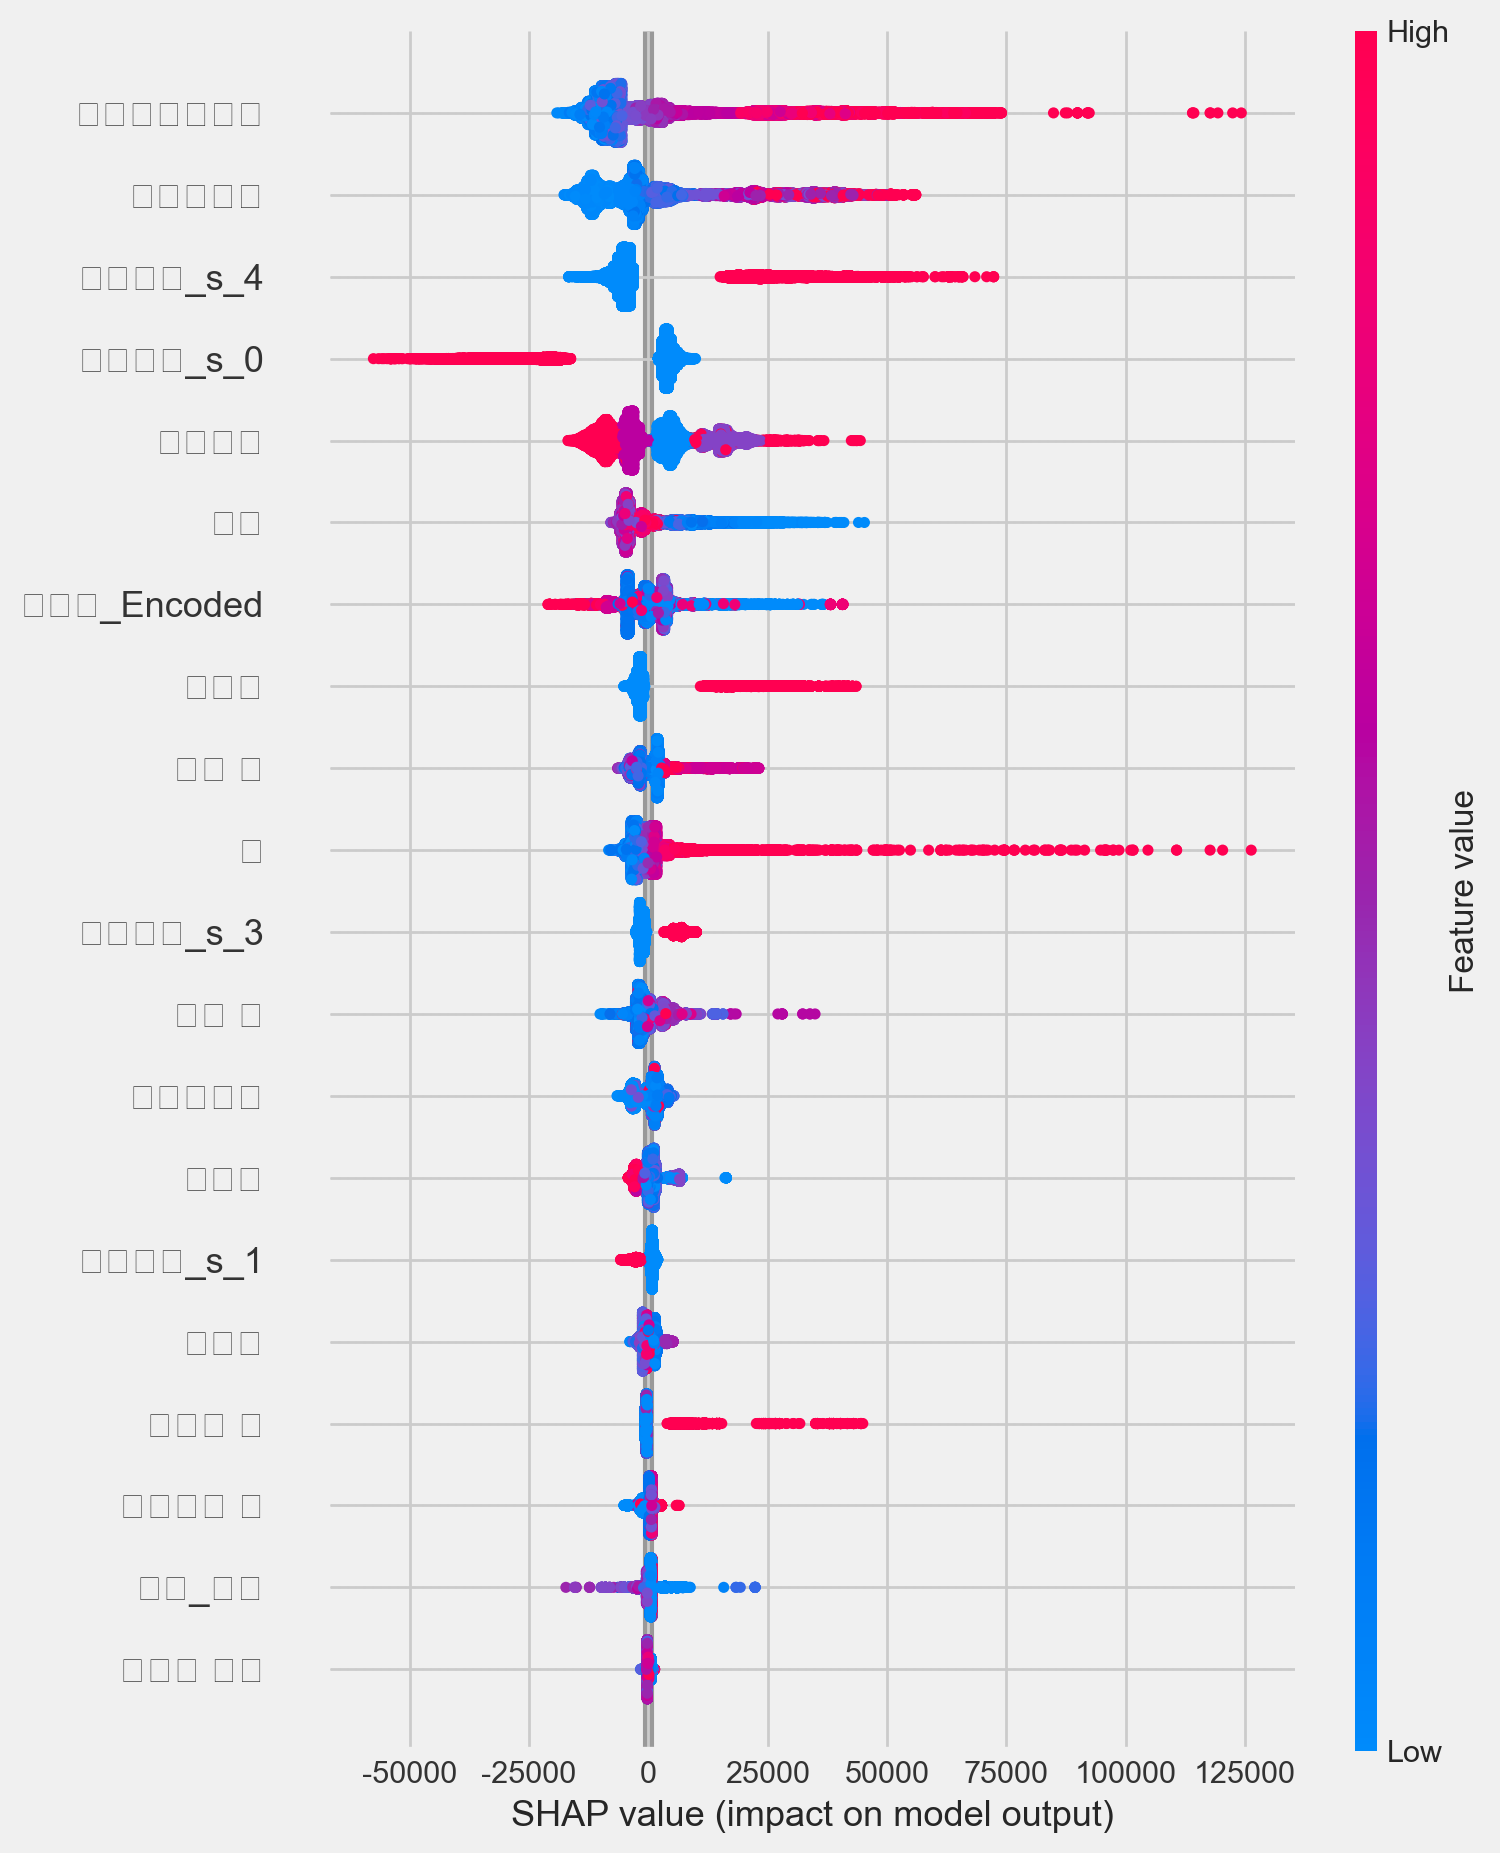

In [126]:
# 피처 중요도 출력
shap.summary_plot(shap_values, X_te_mm_rb)

In [127]:
shap.initjs()
shap.plots.force(shap_values[0])

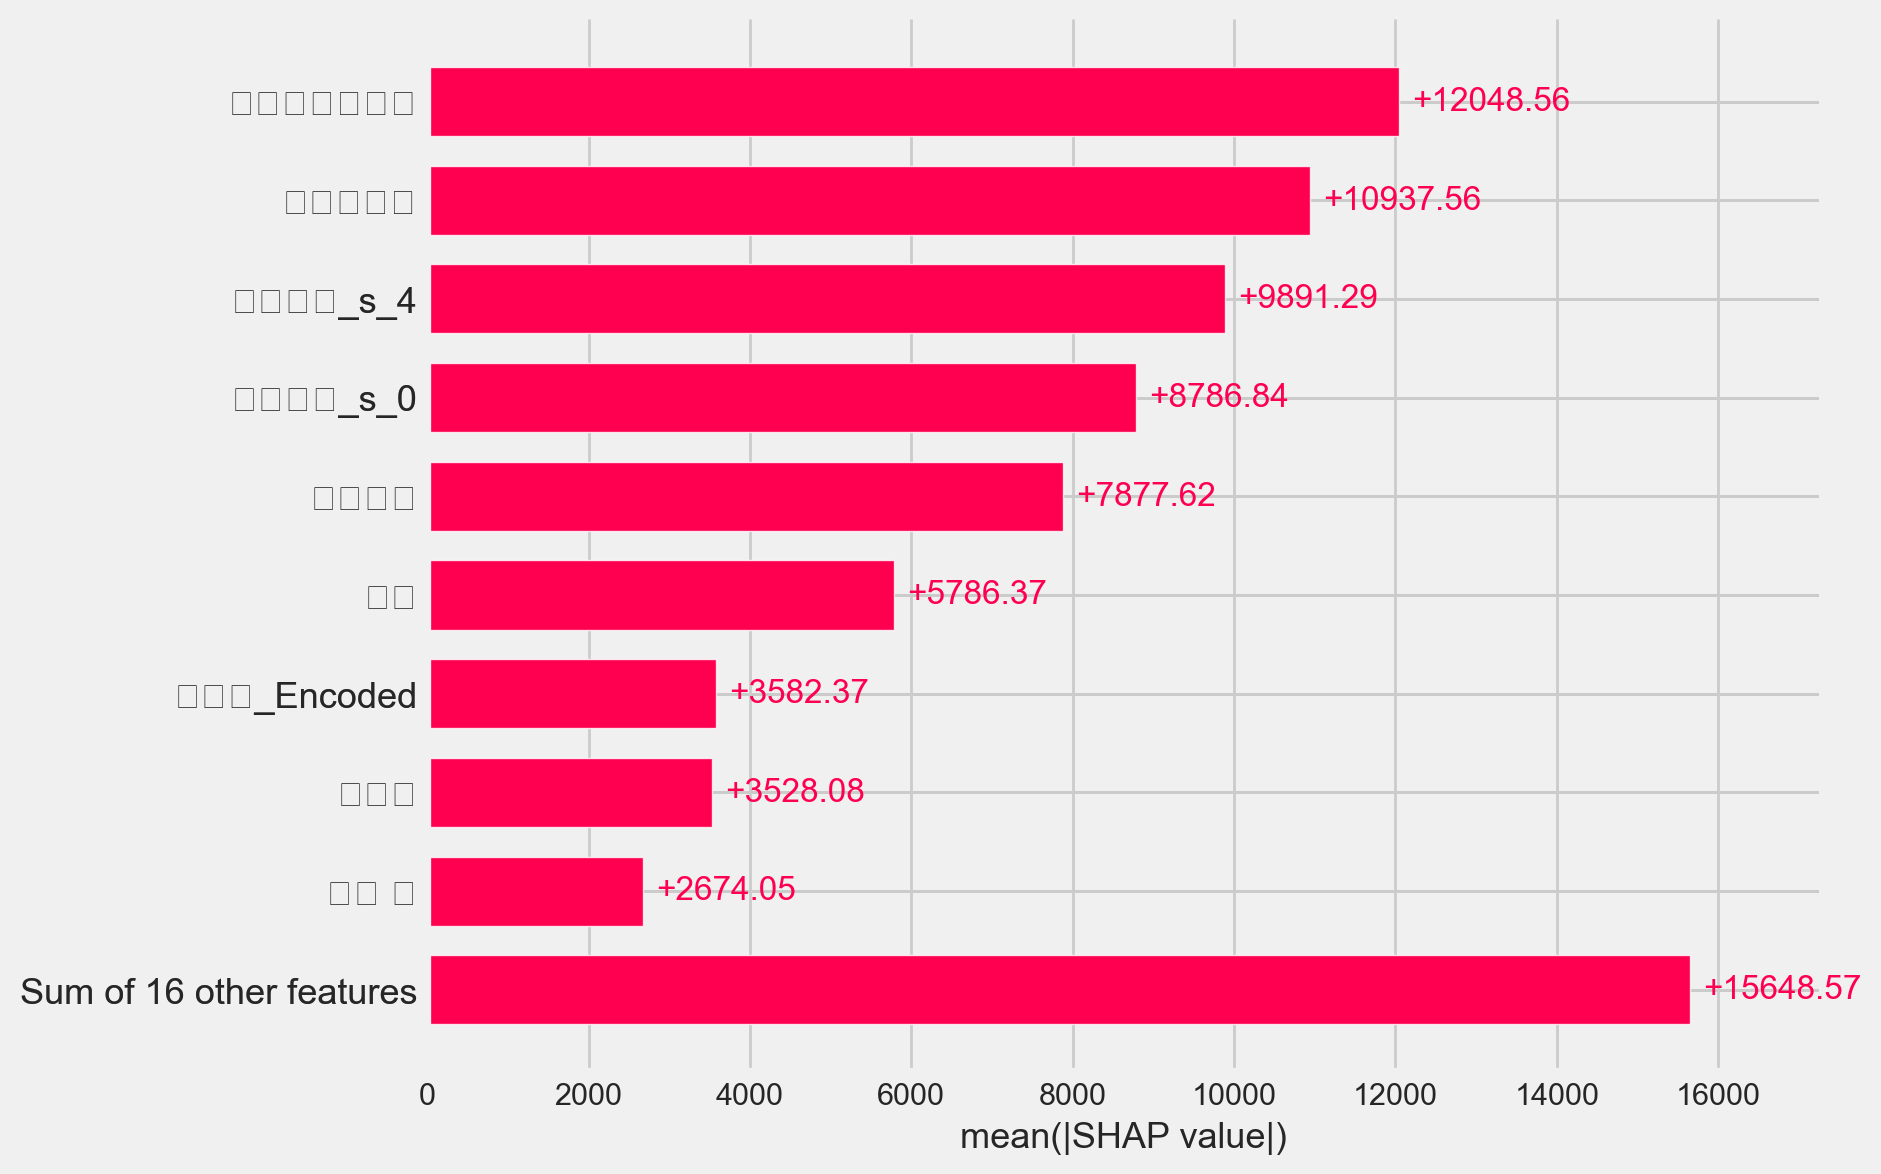

In [128]:
shap.plots.bar(shap_values)

In [129]:
# 변수별 가중치 추출
mean_absolute_shap_values = np.mean(np.abs(shap_values.values), axis=0)
variable_weights = pd.DataFrame(list(zip(X_tr_mm_rb.columns, mean_absolute_shap_values)),
                                columns=['Variable', 'Weight'])
variable_weights = variable_weights.sort_values(by='Weight', ascending=False)

print(variable_weights)

       Variable        Weight
24      월평균소득금액  12048.563533
21        피보험자수  10937.559077
3      전용면적_s_4   9891.289606
11     전용면적_s_0   8786.839376
7          기준금리   7877.620782
15           연식   5786.369643
12  법정동_Encoded   3582.373324
4           재건축   3528.084916
16         병원 수   2674.045390
19            층   2543.858300
6      전용면적_s_3   2475.531776
18         카페 수   2189.825489
14        부동산정책   2028.586493
17          사업체   1398.520320
0      전용면적_s_1   1199.648418
10          학교수    979.885152
9         백화점 수    891.961210
8        지하철역 수    760.494034
13        공원_거리    689.185401
23       부동산 매매    234.178353
20          총전입    172.492170
22          총전출     84.399946
5           공원수      0.000000
1        대형마트 수      0.000000
2      전용면적_s_2      0.000000


## CatBoost

In [149]:
# CatBoost
from catboost import CatBoostRegressor

modelV3_s = CatBoostRegressor(random_seed=42,verbose=0)

print('\nCatBoost')
train_model(modelV3_s,scaled_tr,scaled_te,scaled_tr_name,y_te)


CatBoost


Processing datasets: 100%|███████████████████████████████████████████████████████████████| 5/5 [03:17<00:00, 39.44s/it]


Dataset          MAE         RMSE  R-squared  Adjusted-R-squared
0             X_tr 10140.714818 17629.408074   0.915930            0.915894
1         standard 10140.714818 17629.408074   0.915930            0.915894
2           minmax 10140.714818 17629.408074   0.915930            0.915894
3           robust 10156.710167 17611.040356   0.916105            0.916069
4  standard_robust 10161.840856 17603.600310   0.916176            0.916140

### - Feature Importance

In [150]:
%%time
# SHAP 값 계산
explainer = shap.TreeExplainer(modelV3_s)
shap_values = explainer.shap_values(X_tr_sd)

CPU times: total: 1min 23s
Wall time: 33.9 s


In [151]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_tr_sd.iloc[0,:])

In [152]:
# 변수별 가중치 추출
mean_absolute_shap_values = np.mean(np.abs(shap_values), axis=0)
variable_weights = pd.DataFrame(list(zip(X_tr_sd.columns, mean_absolute_shap_values)),
                                columns=['Variable', 'Weight'])
variable_weights = variable_weights.sort_values(by='Weight', ascending=False)

print(variable_weights)

       Variable       Weight
21       지하철역 수 13323.976315
24         카페 수 12152.156595
1      전용면적_s_0 10378.654117
7            연식 10254.996805
11         기준금리  9306.563590
15        피보험자수  7569.758567
10          공원수  4855.968146
19       부동산 매매  3938.902403
17         병원 수  3876.005817
0           재건축  3489.042192
18          총전출  3467.099930
14          총전입  3152.195550
6      전용면적_s_3  2431.693430
16       대형마트 수  2334.552756
5   법정동_Encoded  1715.083898
13          학교수  1545.805298
8         백화점 수  1465.512507
23        공원_거리  1290.049314
9         부동산정책  1071.509237
22            층  1052.273858
4      전용면적_s_4   779.529549
20      월평균소득금액   646.510901
3      전용면적_s_1   419.420518
2      전용면적_s_2   165.222026
12          사업체   158.050809


### - 최적 파라미터 찾기

In [157]:
class Objective:
    def __init__(self,x_train,y_train,seed):
        self.x_train = x_train
        self.y_train = y_train
        self.seed = seed
        num_folds=2 # 학습시간을 줄이기 위해 2로 하였다. 일반적으로는 5
        self.cv = KFold(n_splits=num_folds,shuffle=True,random_state=self.seed)
    def __call__(self,trial):
        hp = {
            "iterations" : trial.suggest_int("iterations",100,2000,100),
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
            "depth": trial.suggest_int("depth", 6, 16, 2),
            "subsample": trial.suggest_float("subsample", 0.05, 1.0),
            "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        }
        model = CatBoostRegressor(random_state=self.seed,**hp, verbose=False, eval_metric="RMSE")
        scores = cross_val_score(model,self.x_train,self.y_train, cv = self.cv, scoring='r2')
        return np.mean(scores)

#### - 학습

In [158]:
%%time
sampler = TPESampler(seed=args.random_state) # 대체모델 부분

# 스터디 객체
study = optuna.create_study(
    direction = "maximize", # maximize or minimize
    sampler = sampler
)
objective = Objective(X_tr_rb,y_tr_rb,args.random_state)
study.optimize(objective,n_trials=50)

print("Best Score:", study.best_value) # 최고점수
print("Best hp", study.best_params) # 최고점수의 하이퍼파라미터조합

Best Score: 0.9304750616113232
Best hp {'iterations': 1800, 'learning_rate': 0.09681033459572587, 'depth': 10, 'subsample': 0.9802481123115082, 'colsample_bylevel': 0.46439586248518316, 'min_data_in_leaf': 44}
CPU times: total: 14h 57min 12s
Wall time: 6h 8min 51s


In [159]:
%%time
model = CatBoostRegressor(random_state=args.random_state, **study.best_params, verbose=False)
model.fit(X_tr_rb,y_tr_rb)

CPU times: total: 5min 45s
Wall time: 3min


#### - 평가

In [161]:
%%time
pred = model.predict(X_te_rb)

CPU times: total: 3.09 s
Wall time: 633 ms


In [162]:
pred

array([398532.7939366 ,  53560.83967732, 147885.85754528, ...,
       156009.6823993 ,  89939.25171191,  54202.5654078 ])

In [163]:
# 평가 지표 계산
rmse = mean_squared_error(y_te_rb, pred, squared=False)
mae = mean_absolute_error(y_te_rb, pred)
r2 = r2_score(y_te_rb, pred)

In [164]:
# 자유도 조정 결정계수를 계산하는 함수를 정의한다.
def adj_r2_score(y_true, y_pred, p=X_tr_rb.shape[1]):
    return 1-(1-r2_score(y_true, y_pred)) * (len(y_true)-1) / (len(y_true) - p - 1)

In [165]:
print("RMSE:", rmse)
print("MAE:", mae)
print("R-squared:", r2)
print("Adjusted R-squared:", adj_r2_score(y_te_rb, pred))

RMSE: 15358.351980304775
MAE: 7871.394134404215
R-squared: 0.9361951705202525
Adjusted R-squared: 0.9361678820415


#### - Feature Importance

In [166]:
%%time
# SHAP 값 계산
explainer = shap.Explainer(model)
shap_values = explainer(X_te_rb)

CPU times: total: 45min 13s
Wall time: 9min 19s


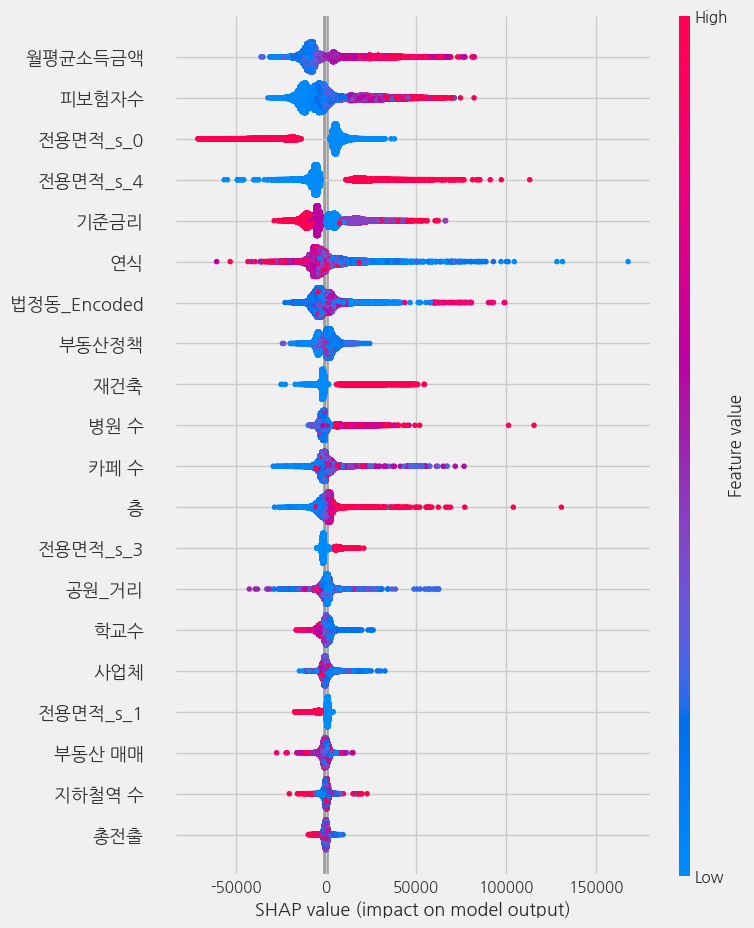

In [167]:
# 피처 중요도 출력
shap.summary_plot(shap_values, X_te_rb)

In [168]:
shap.initjs()
shap.plots.force(shap_values[0])

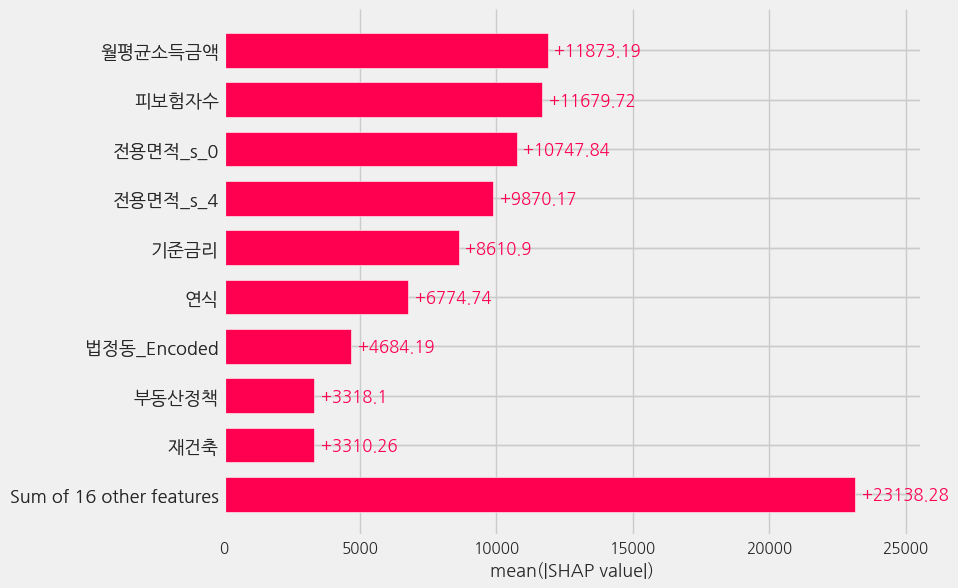

In [169]:
shap.plots.bar(shap_values)

In [170]:
# 변수별 가중치 추출
mean_absolute_shap_values = np.mean(np.abs(shap_values.values), axis=0)
variable_weights = pd.DataFrame(list(zip(X_tr_rb.columns, mean_absolute_shap_values)),
                                columns=['Variable', 'Weight'])
variable_weights = variable_weights.sort_values(by='Weight', ascending=False)

print(variable_weights)

       Variable       Weight
13      월평균소득금액 11873.188996
8         피보험자수 11679.724847
20     전용면적_s_0 10747.838546
24     전용면적_s_4  9870.173198
18         기준금리  8610.900746
14           연식  6774.735239
17  법정동_Encoded  4684.189917
19        부동산정책  3318.096707
6           재건축  3310.258439
4          병원 수  3057.060006
9          카페 수  2813.351102
12            층  2639.864239
23     전용면적_s_3  2479.157527
2         공원_거리  1948.172683
1           학교수  1914.955990
3           사업체  1646.057829
21     전용면적_s_1  1617.280748
10       부동산 매매  1257.432967
16       지하철역 수   831.978970
0           총전출   723.991141
15          총전입   697.729574
11        백화점 수   535.918024
22     전용면적_s_2   461.855474
5           공원수   267.546329
7        대형마트 수   245.930382


In [171]:
variable_weights['Variable'].values

array(['월평균소득금액', '피보험자수', '전용면적_s_0', '전용면적_s_4', '기준금리', '연식',
       '법정동_Encoded', '부동산정책', '재건축', '병원 수', '카페 수', '층', '전용면적_s_3',
       '공원_거리', '학교수', '사업체', '전용면적_s_1', '부동산 매매', '지하철역 수', '총전출',
       '총전입', '백화점 수', '전용면적_s_2', '공원수', '대형마트 수'], dtype=object)

In [206]:
model.save_model('CatBoost.cbm')

## XGBoost

In [148]:
# XGBoost
from xgboost import XGBRegressor

modelV4_s = XGBRegressor(random_state=42)

print('\nXgboost')
train_model(modelV4_s,scaled_tr,scaled_te,scaled_tr_name,y_te)


Xgboost


Processing datasets: 100%|███████████████████████████████████████████████████████████████| 5/5 [01:42<00:00, 20.43s/it]


Dataset           MAE          RMSE  R-squared  Adjusted-R-squared
0             X_tr  10432.891847  17824.041259   0.914064            0.914027
1         standard  10433.479287  17827.881135   0.914027            0.913990
2           minmax  10433.435725  17827.495372   0.914030            0.913994
3           robust  10434.910114  17825.687982   0.914048            0.914011
4  standard_robust  10433.566018  17818.441339   0.914118            0.914081

### - Feature Importance

In [149]:
%%time
# SHAP 값 계산
explainer = shap.Explainer(modelV4_s, X_tr_mm_rb)
shap_values = explainer(X_te_mm_rb)

100%|===================| 58396/58480 [06:58<00:00]        

CPU times: total: 3min 18s
Wall time: 6min 59s


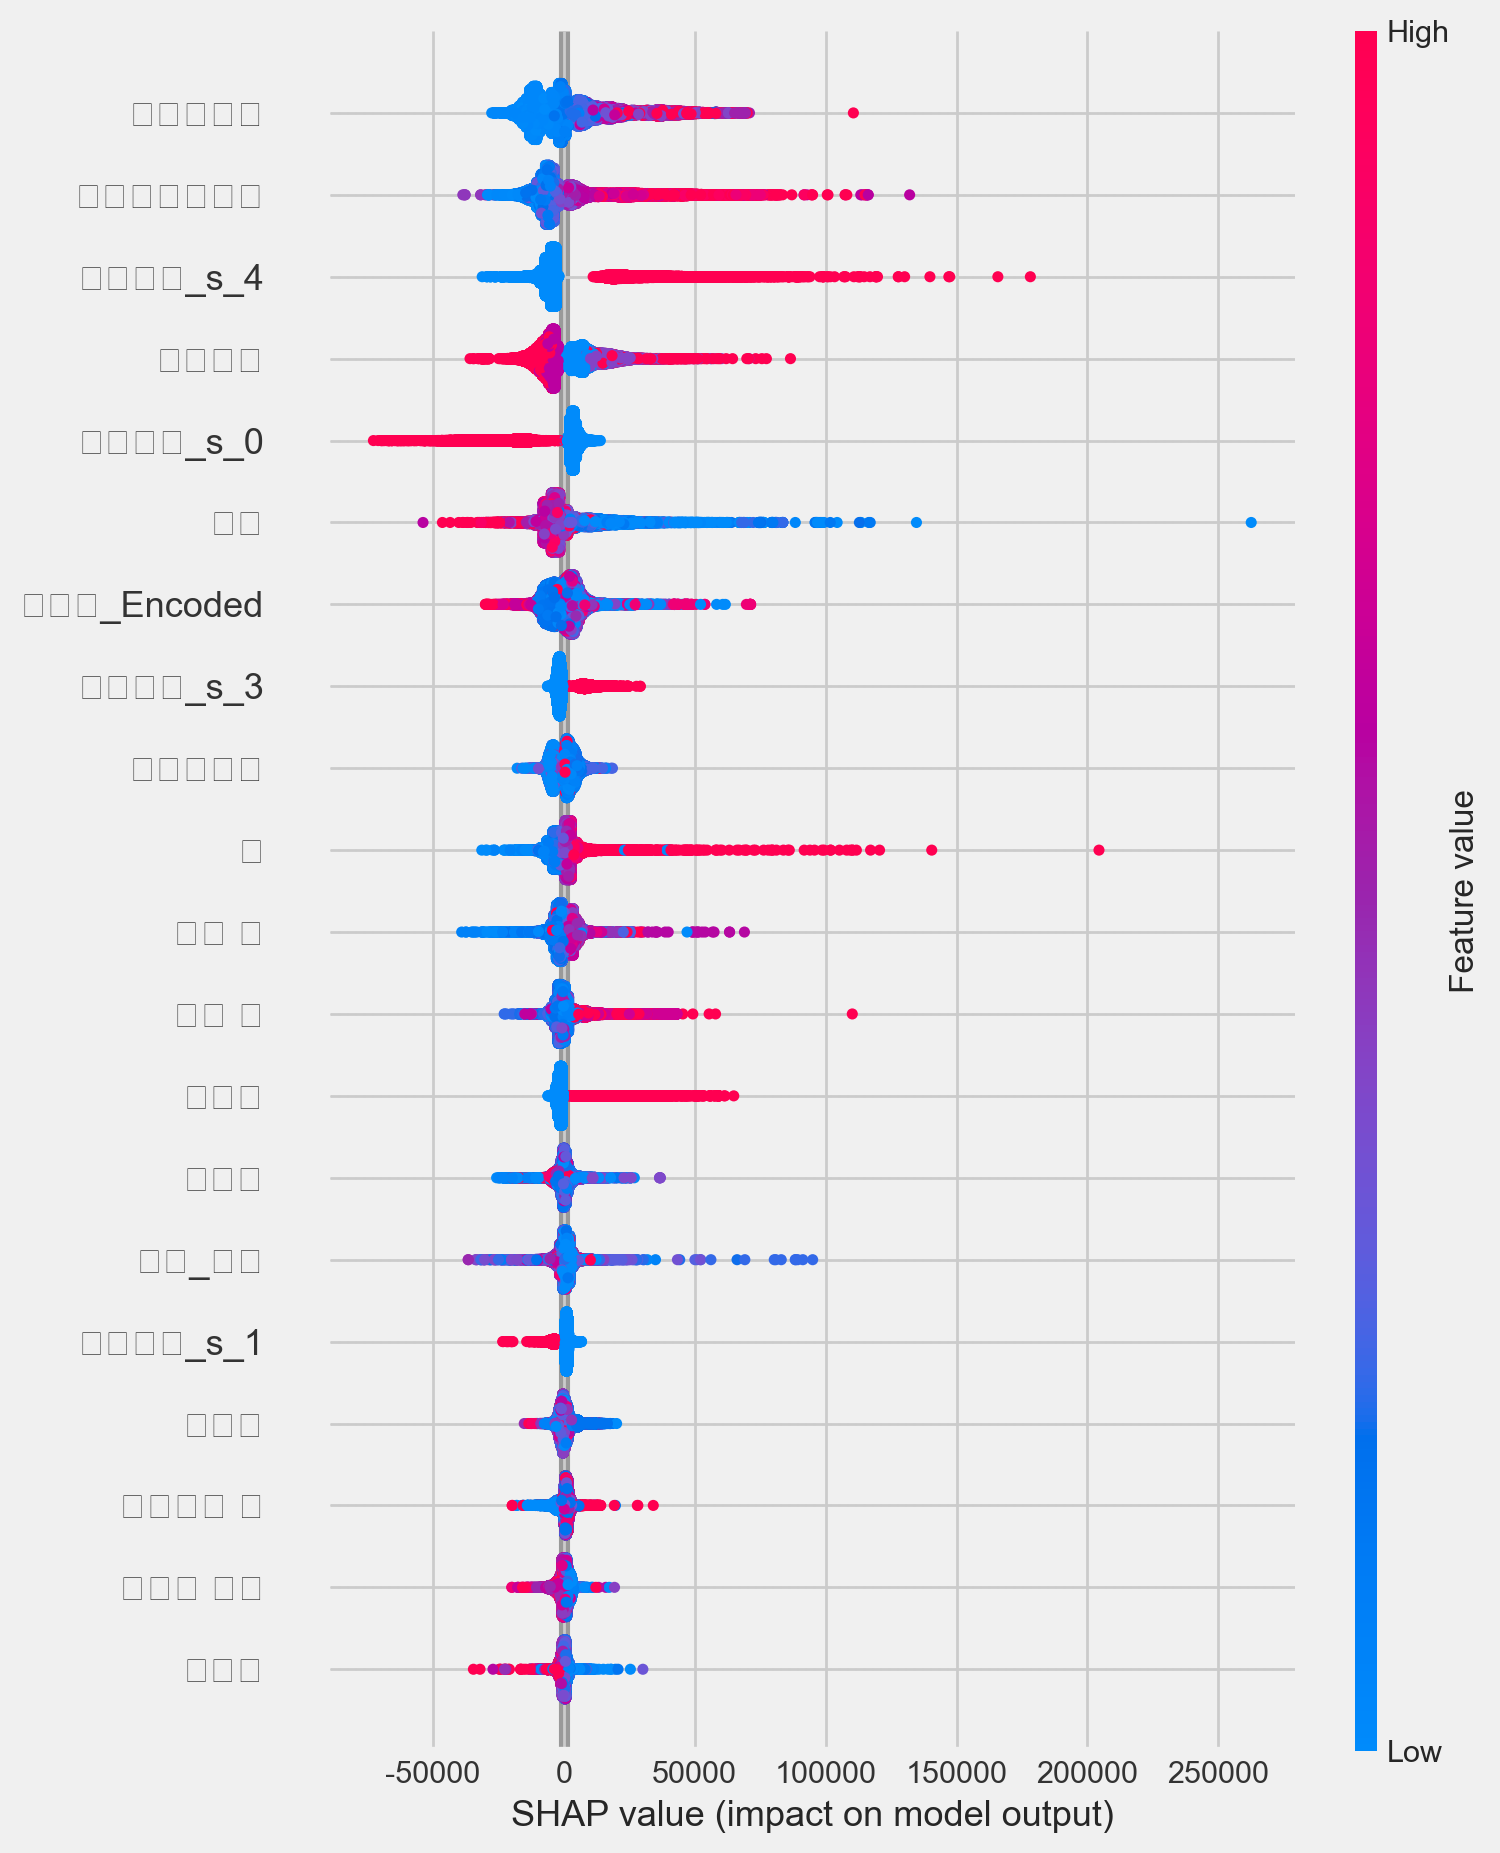

In [150]:
# 피처 중요도 출력
shap.summary_plot(shap_values, X_te_mm_rb)

In [151]:
shap.initjs()
shap.plots.force(shap_values[0])

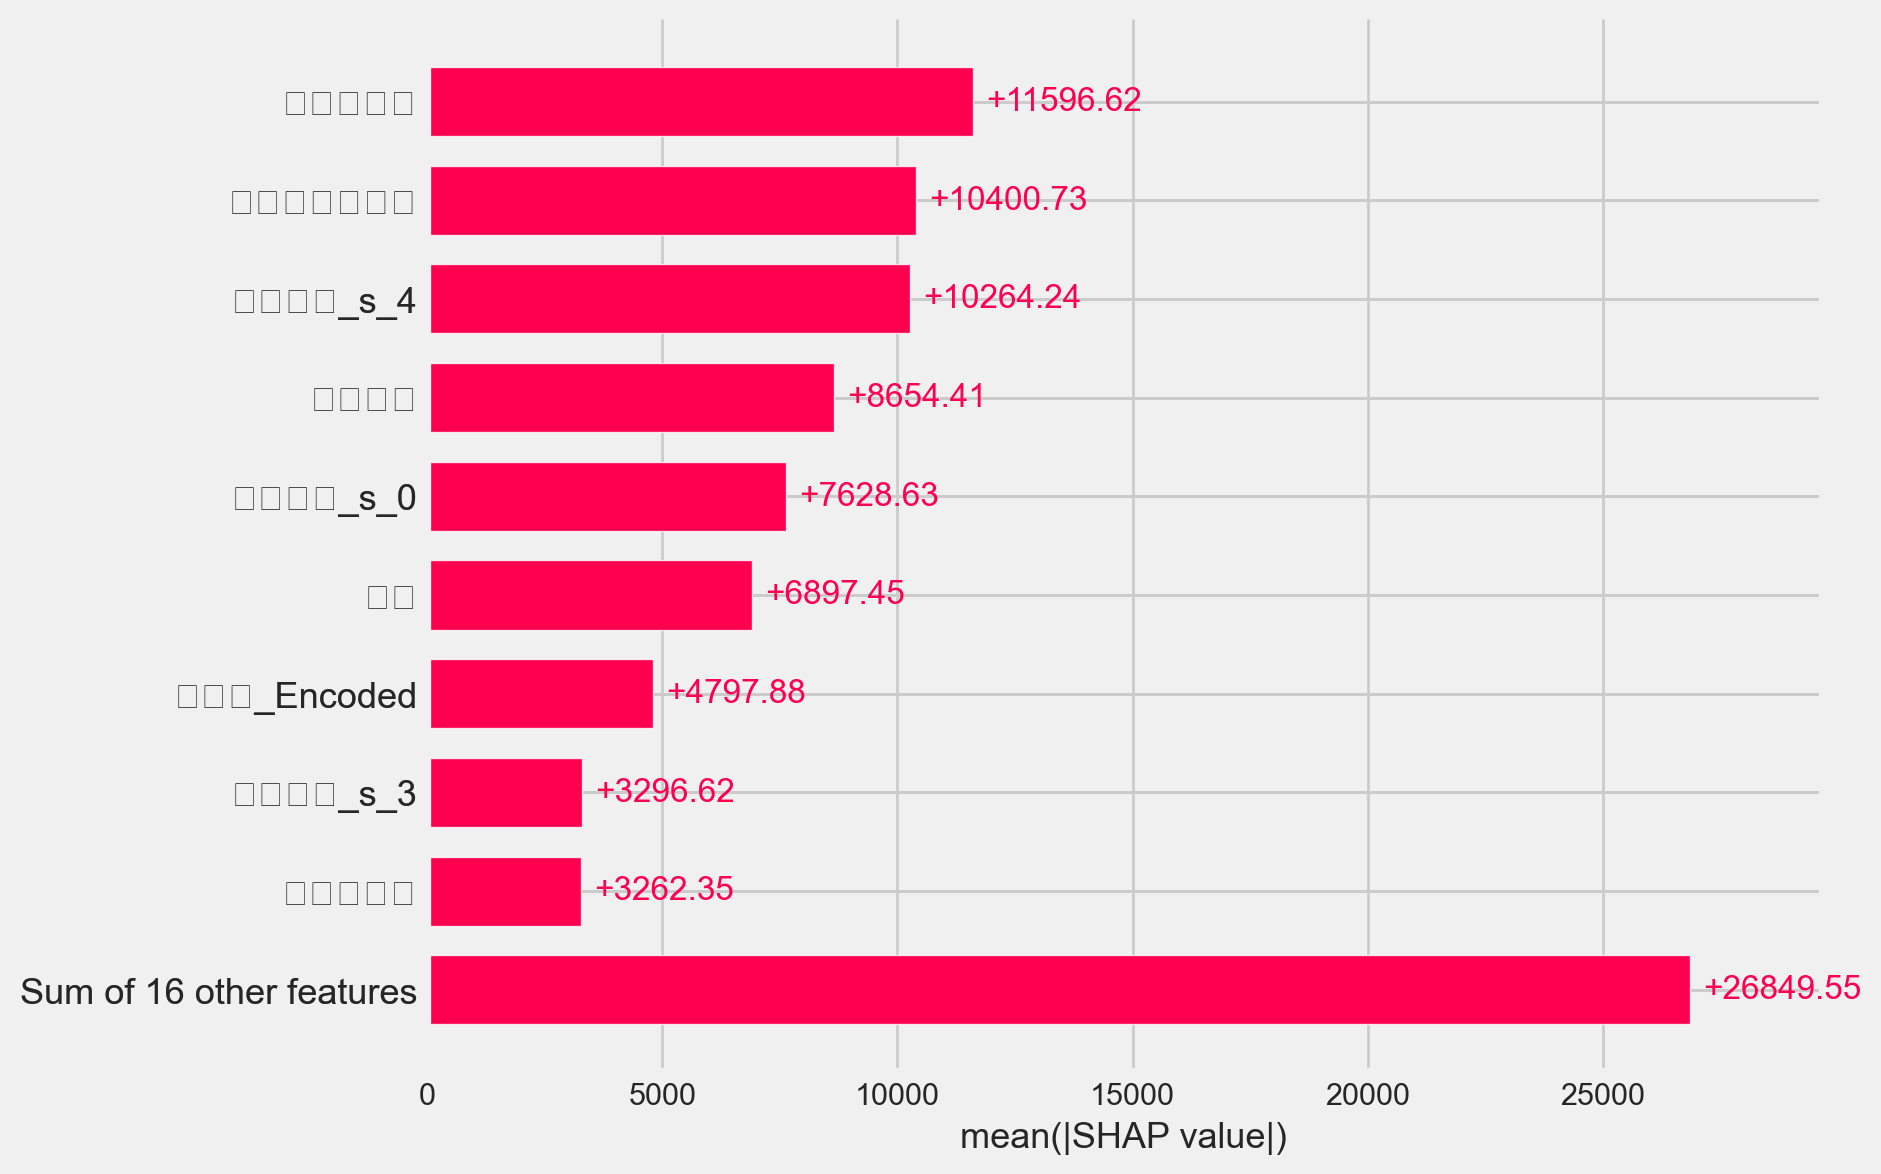

In [152]:
shap.plots.bar(shap_values)

In [153]:
# 변수별 가중치 추출
mean_absolute_shap_values = np.mean(np.abs(shap_values.values), axis=0)
variable_weights = pd.DataFrame(list(zip(X_tr_mm_rb.columns, mean_absolute_shap_values)),
                                columns=['Variable', 'Weight'])
variable_weights = variable_weights.sort_values(by='Weight', ascending=False)

print(variable_weights)

       Variable        Weight
21        피보험자수  11596.621039
24      월평균소득금액  10400.726511
3      전용면적_s_4  10264.235247
7          기준금리   8654.414408
11     전용면적_s_0   7628.625802
15           연식   6897.446359
12  법정동_Encoded   4797.877897
6      전용면적_s_3   3296.618669
14        부동산정책   3262.354202
19            층   3099.382779
18         카페 수   3038.515663
16         병원 수   3020.917393
4           재건축   2951.194286
17          사업체   2049.959183
13        공원_거리   1983.064399
0      전용면적_s_1   1718.962652
10          학교수   1703.751269
8        지하철역 수   1538.555466
23       부동산 매매   1521.040897
20          총전입    985.627391
9         백화점 수    944.879547
22          총전출    887.530795
2      전용면적_s_2    637.167869
1        대형마트 수    436.960880
5           공원수    332.040698


## LightGBM

In [154]:
# 선형 회귀 모델 생성 및 훈련
from lightgbm import LGBMRegressor

modelV5_s = LGBMRegressor(random_state=42)

print('\nLightgbm')
train_model(modelV5_s,scaled_tr,scaled_te,scaled_tr_name,y_te)


Lightgbm


Processing datasets:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 233916, number of used features: 25
[LightGBM] [Info] Start training from score 82066.543738


Processing datasets:  20%|████████████▌                                                  | 1/5 [00:03<00:15,  3.79s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2064
[LightGBM] [Info] Number of data points in the train set: 233916, number of used features: 25
[LightGBM] [Info] Start training from score 82066.543738


Processing datasets:  40%|█████████████████████████▏                                     | 2/5 [00:07<00:10,  3.58s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025775 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2095
[LightGBM] [Info] Number of data points in the train set: 233916, number of used features: 25
[LightGBM] [Info] Start training from score 82066.543738


Processing datasets:  60%|█████████████████████████████████████▊                         | 3/5 [00:10<00:06,  3.38s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2099
[LightGBM] [Info] Number of data points in the train set: 233916, number of used features: 25
[LightGBM] [Info] Start training from score 82066.543738


Processing datasets:  80%|██████████████████████████████████████████████████▍            | 4/5 [00:13<00:03,  3.44s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2049
[LightGBM] [Info] Number of data points in the train set: 233916, number of used features: 25
[LightGBM] [Info] Start training from score 82066.543738


Processing datasets: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:17<00:00,  3.51s/it]


Dataset           MAE          RMSE  R-squared  Adjusted-R-squared
0             X_tr  12443.186791  20237.486621   0.889216            0.889169
1         standard  12431.467999  20171.804896   0.889934            0.889887
2           minmax  12435.150648  20207.242916   0.889547            0.889500
3           robust  12435.022430  20207.162030   0.889548            0.889500
4  standard_robust  12443.186791  20237.486621   0.889216            0.889169

### - Feature Importance

In [155]:
%%time
# SHAP 값 계산
explainer = shap.Explainer(modelV5_s, X_tr_sd)
shap_values = explainer(X_te_sd)

100%|===================| 58341/58480 [06:26<00:00]        

CPU times: total: 2min 59s
Wall time: 6min 27s


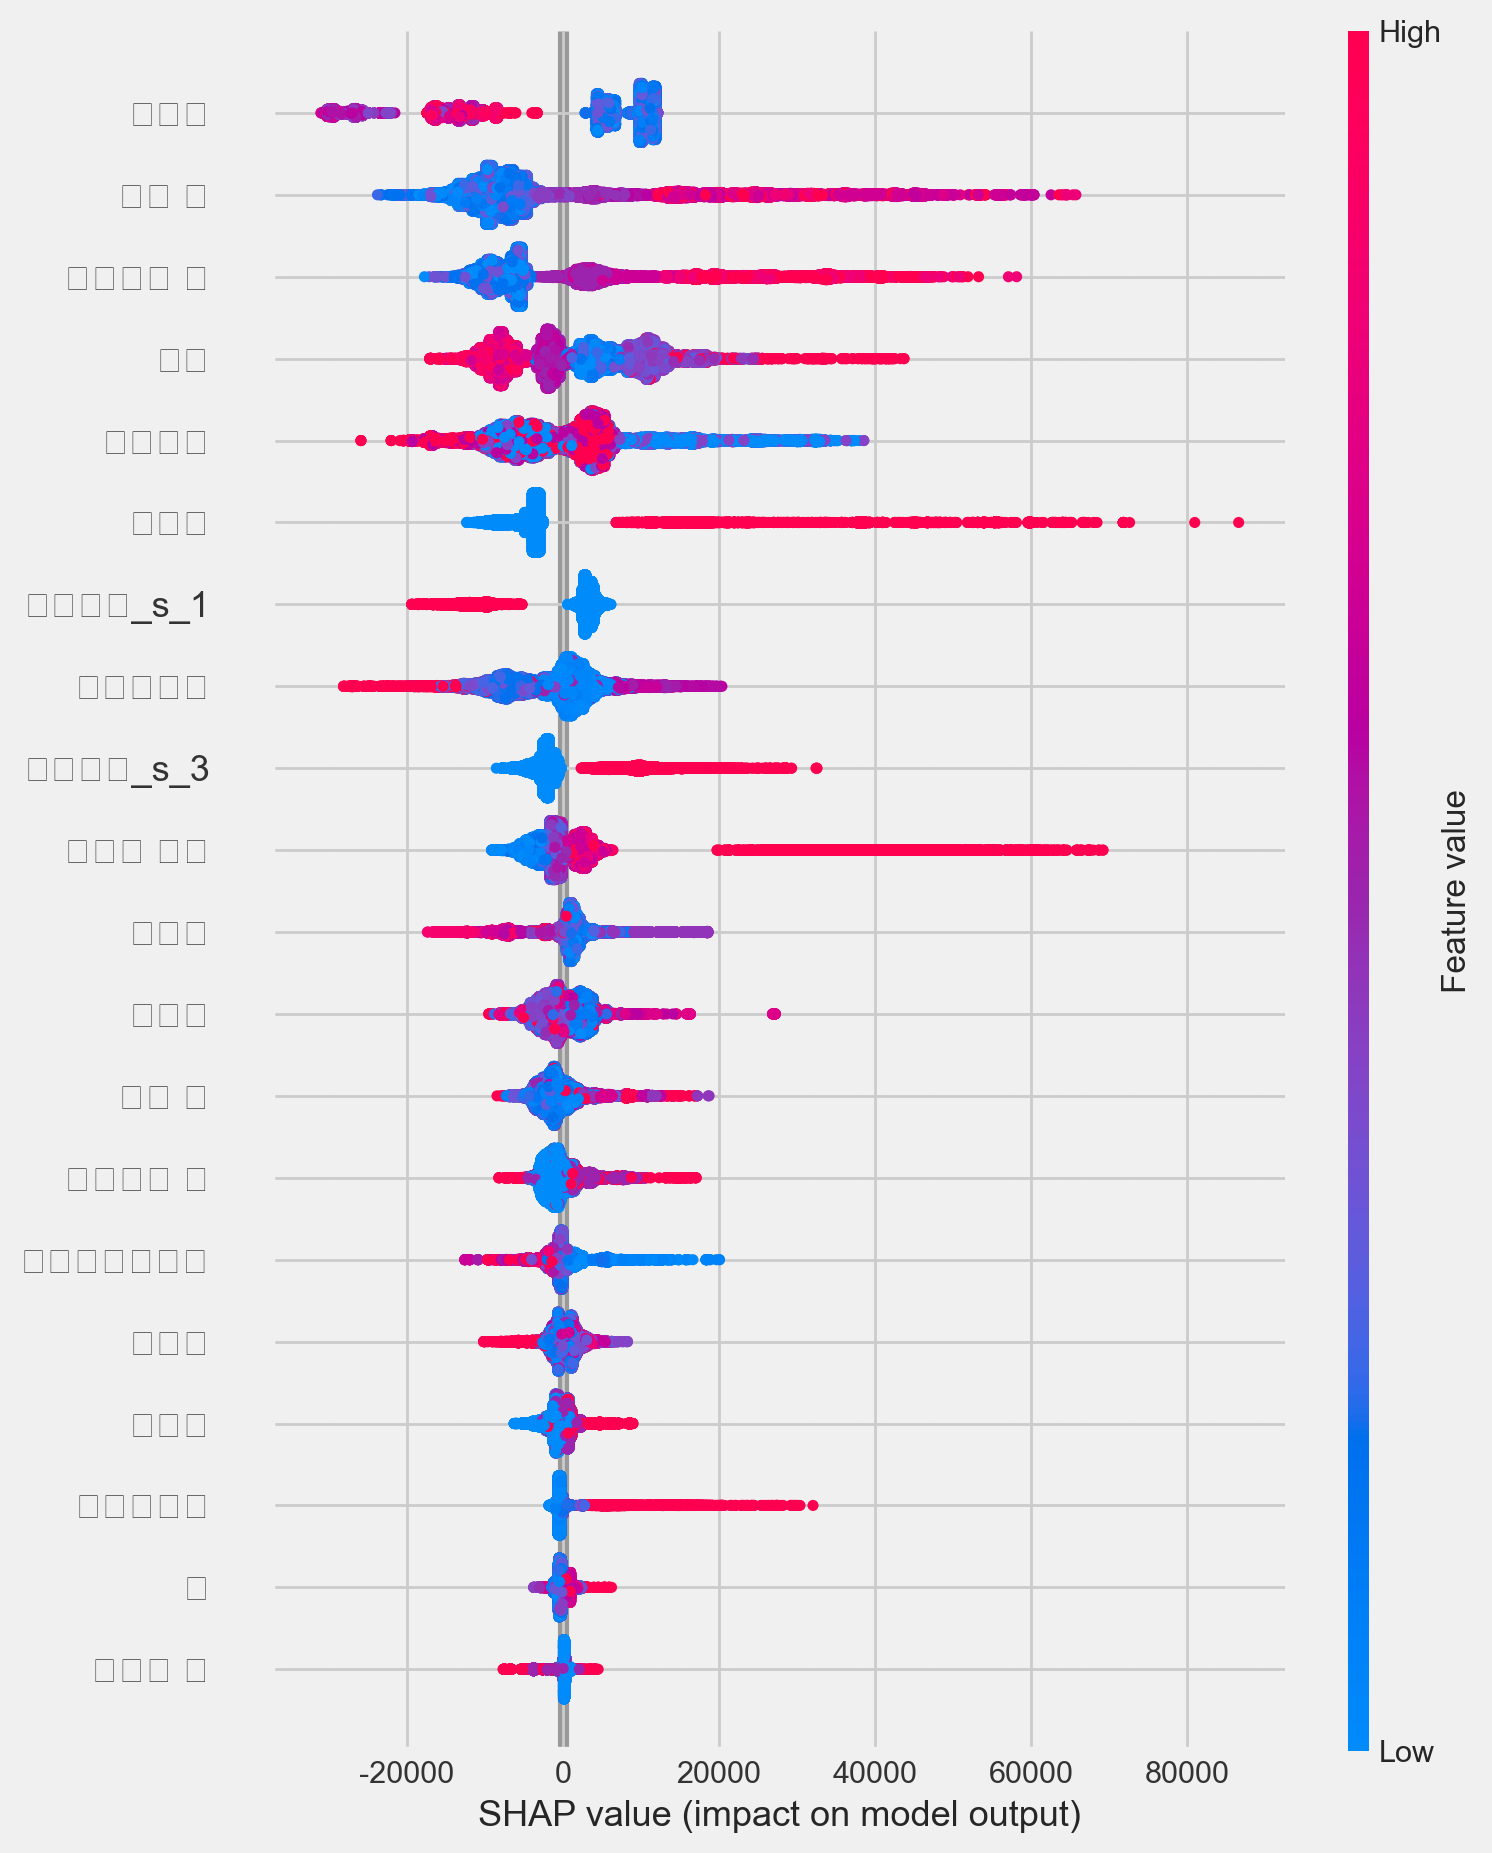

In [156]:
# 피처 중요도 출력
shap.summary_plot(shap_values, X_te_sd)

In [157]:
shap.initjs()
shap.plots.force(shap_values[0])

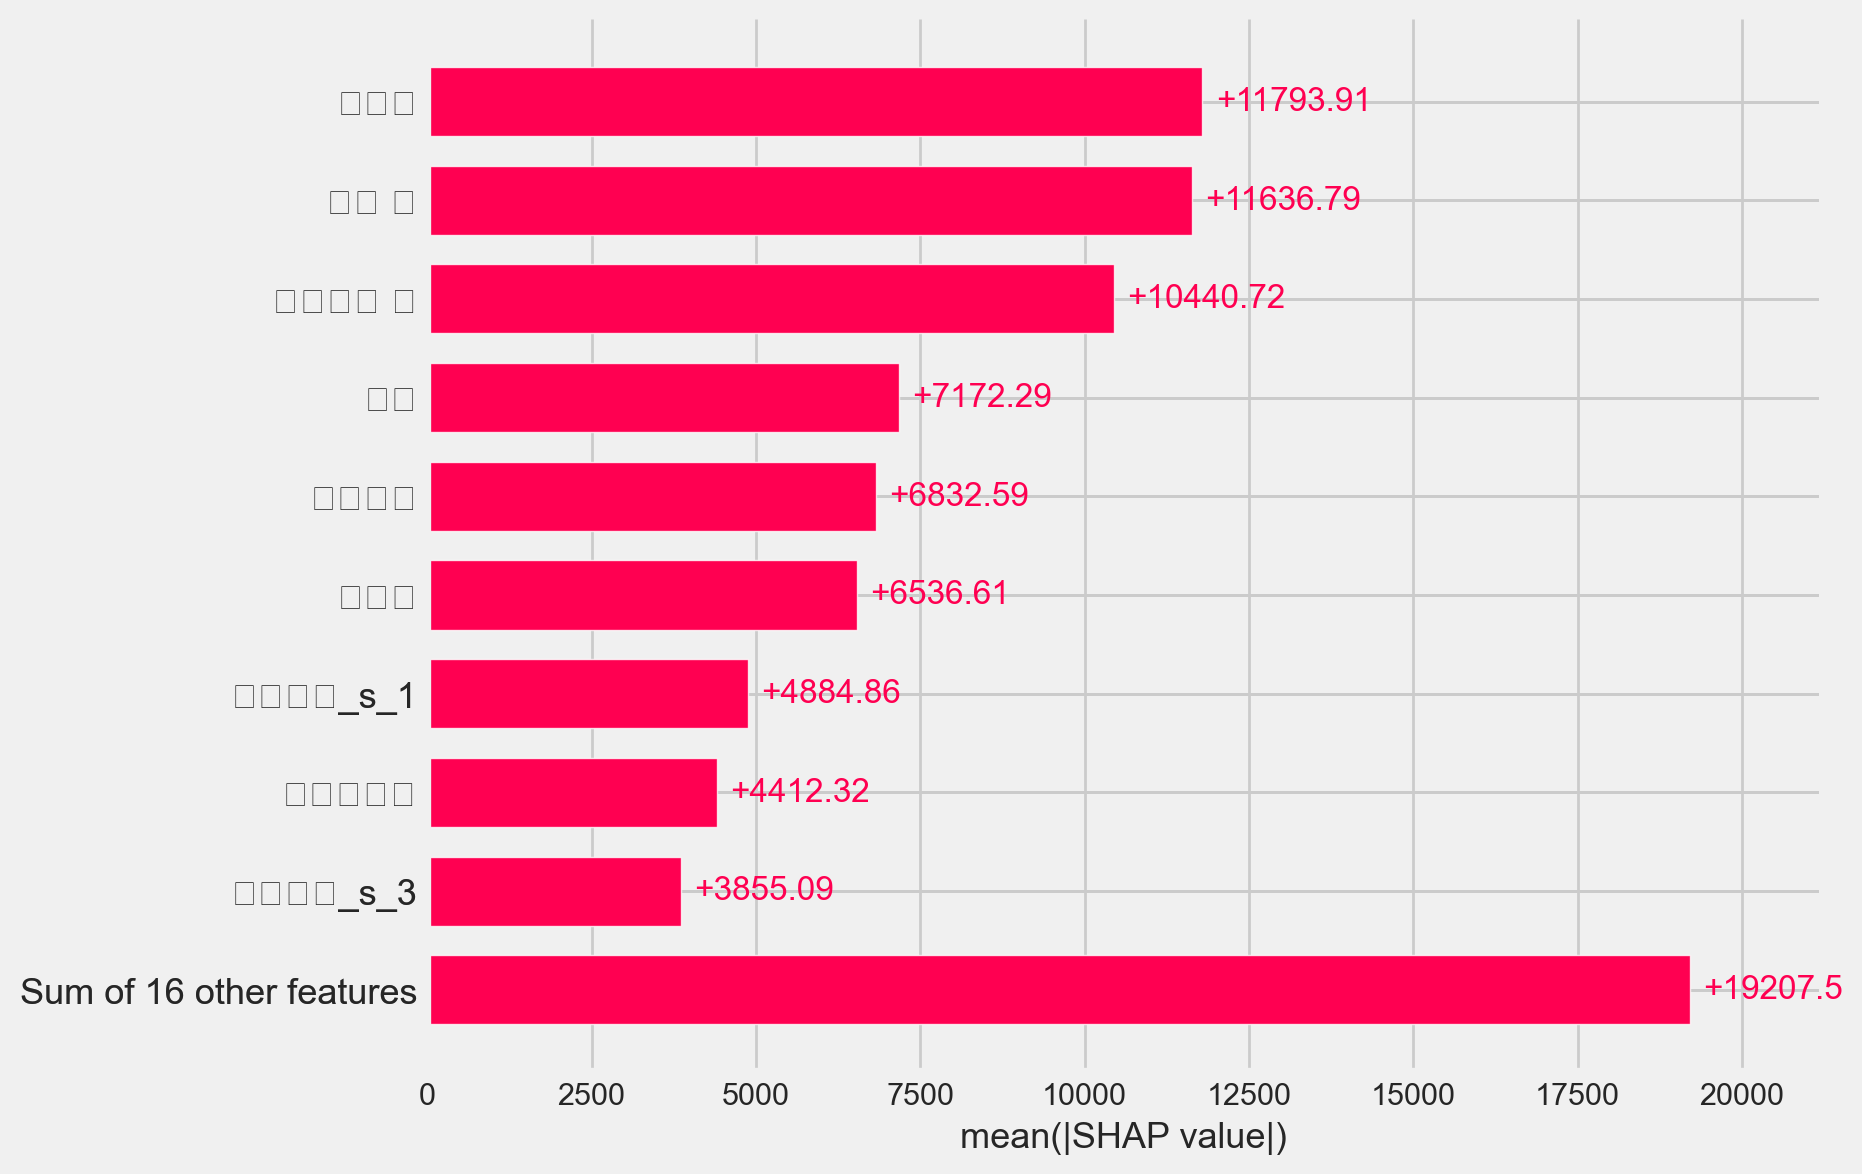

In [158]:
shap.plots.bar(shap_values)

In [159]:
# 변수별 가중치 추출
mean_absolute_shap_values = np.mean(np.abs(shap_values.values), axis=0)
variable_weights = pd.DataFrame(list(zip(X_tr_sd.columns, mean_absolute_shap_values)),
                                columns=['Variable', 'Weight'])
variable_weights = variable_weights.sort_values(by='Weight', ascending=False)

print(variable_weights)

       Variable        Weight
12          사업체  11793.906890
24         카페 수  11636.793656
21       지하철역 수  10440.717940
7            연식   7172.292559
11         기준금리   6832.590733
3           재건축   6536.610096
0      전용면적_s_1   4884.855306
15        피보험자수   4412.319637
4      전용면적_s_3   3855.092533
19       부동산 매매   3506.119537
13          학교수   2832.036844
18          총전출   2271.441189
17         병원 수   2108.823916
16       대형마트 수   1847.883952
20      월평균소득금액   1506.225347
14          총전입   1349.583179
10          공원수   1114.012085
9         부동산정책    922.135339
22            층    594.027397
8         백화점 수    490.094588
23        공원_거리    469.610628
2      전용면적_s_4    112.574875
1      전용면적_s_2     46.258725
6   법정동_Encoded     36.603781
5      전용면적_s_0      0.073303


## Support Vector Regressor(SVR)

In [ ]:
%%time
# SVR
from sklearn.svm import SVR

modelV6_s = SVR()

print('\nSVR')
train_model(modelV6_s,scaled_tr,scaled_te,scaled_tr_name,y_te)

### - Feature Importance

In [155]:
%%time
# SHAP 값 계산
explainer = shap.Explainer(modelV6_s, X_tr_sd)
shap_values = explainer(X_te_sd)

100%|===================| 58341/58480 [06:26<00:00]        

CPU times: total: 2min 59s
Wall time: 6min 27s


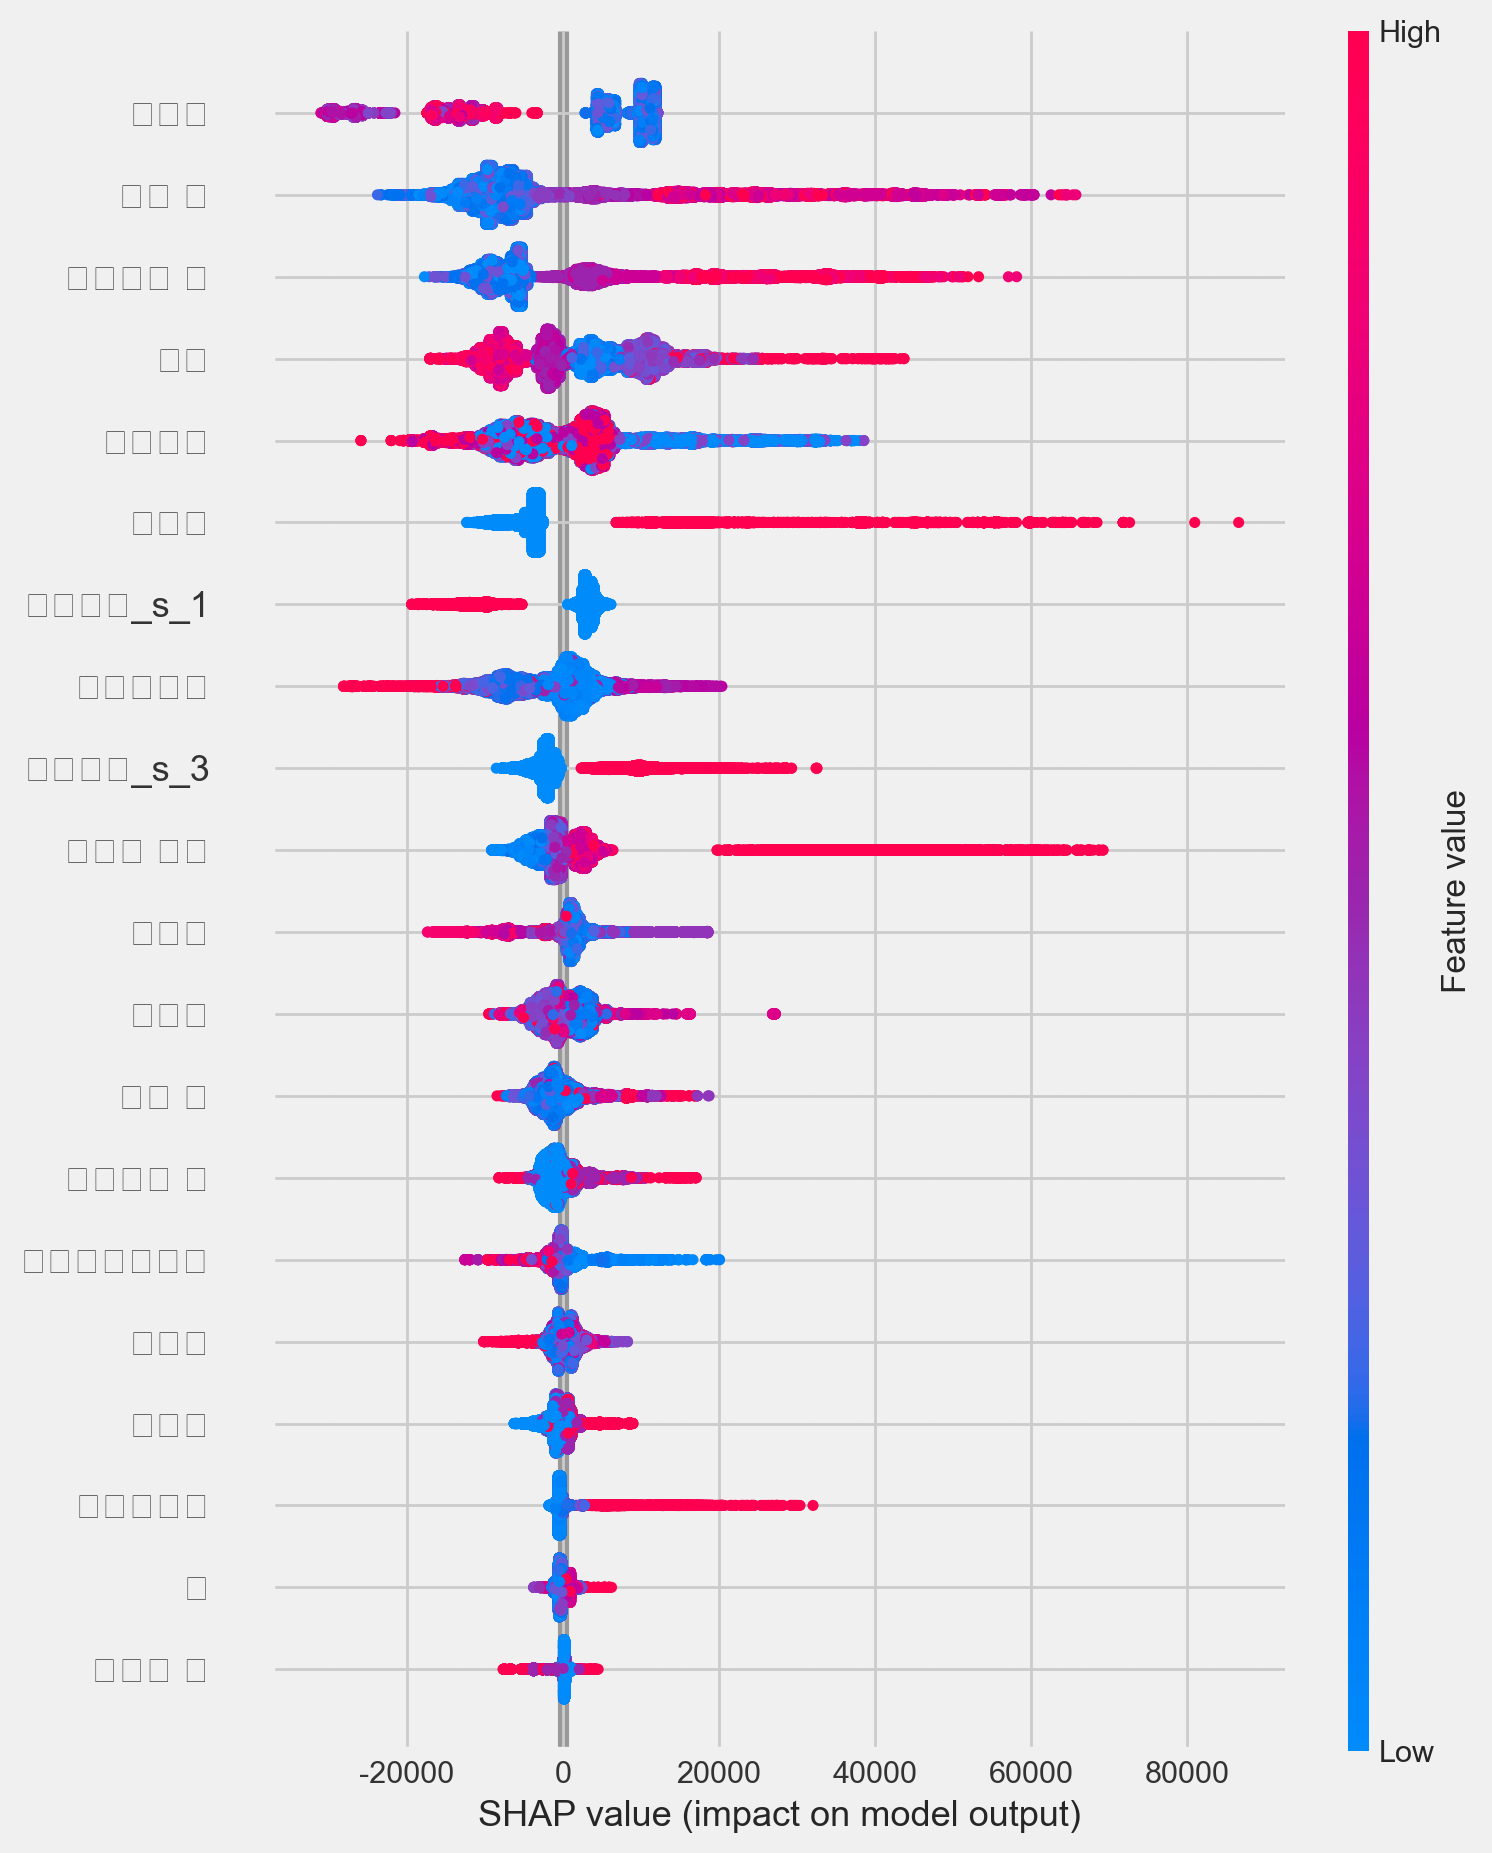

In [156]:
# 피처 중요도 출력
shap.summary_plot(shap_values, X_te_sd)

In [157]:
shap.initjs()
shap.plots.force(shap_values[0])

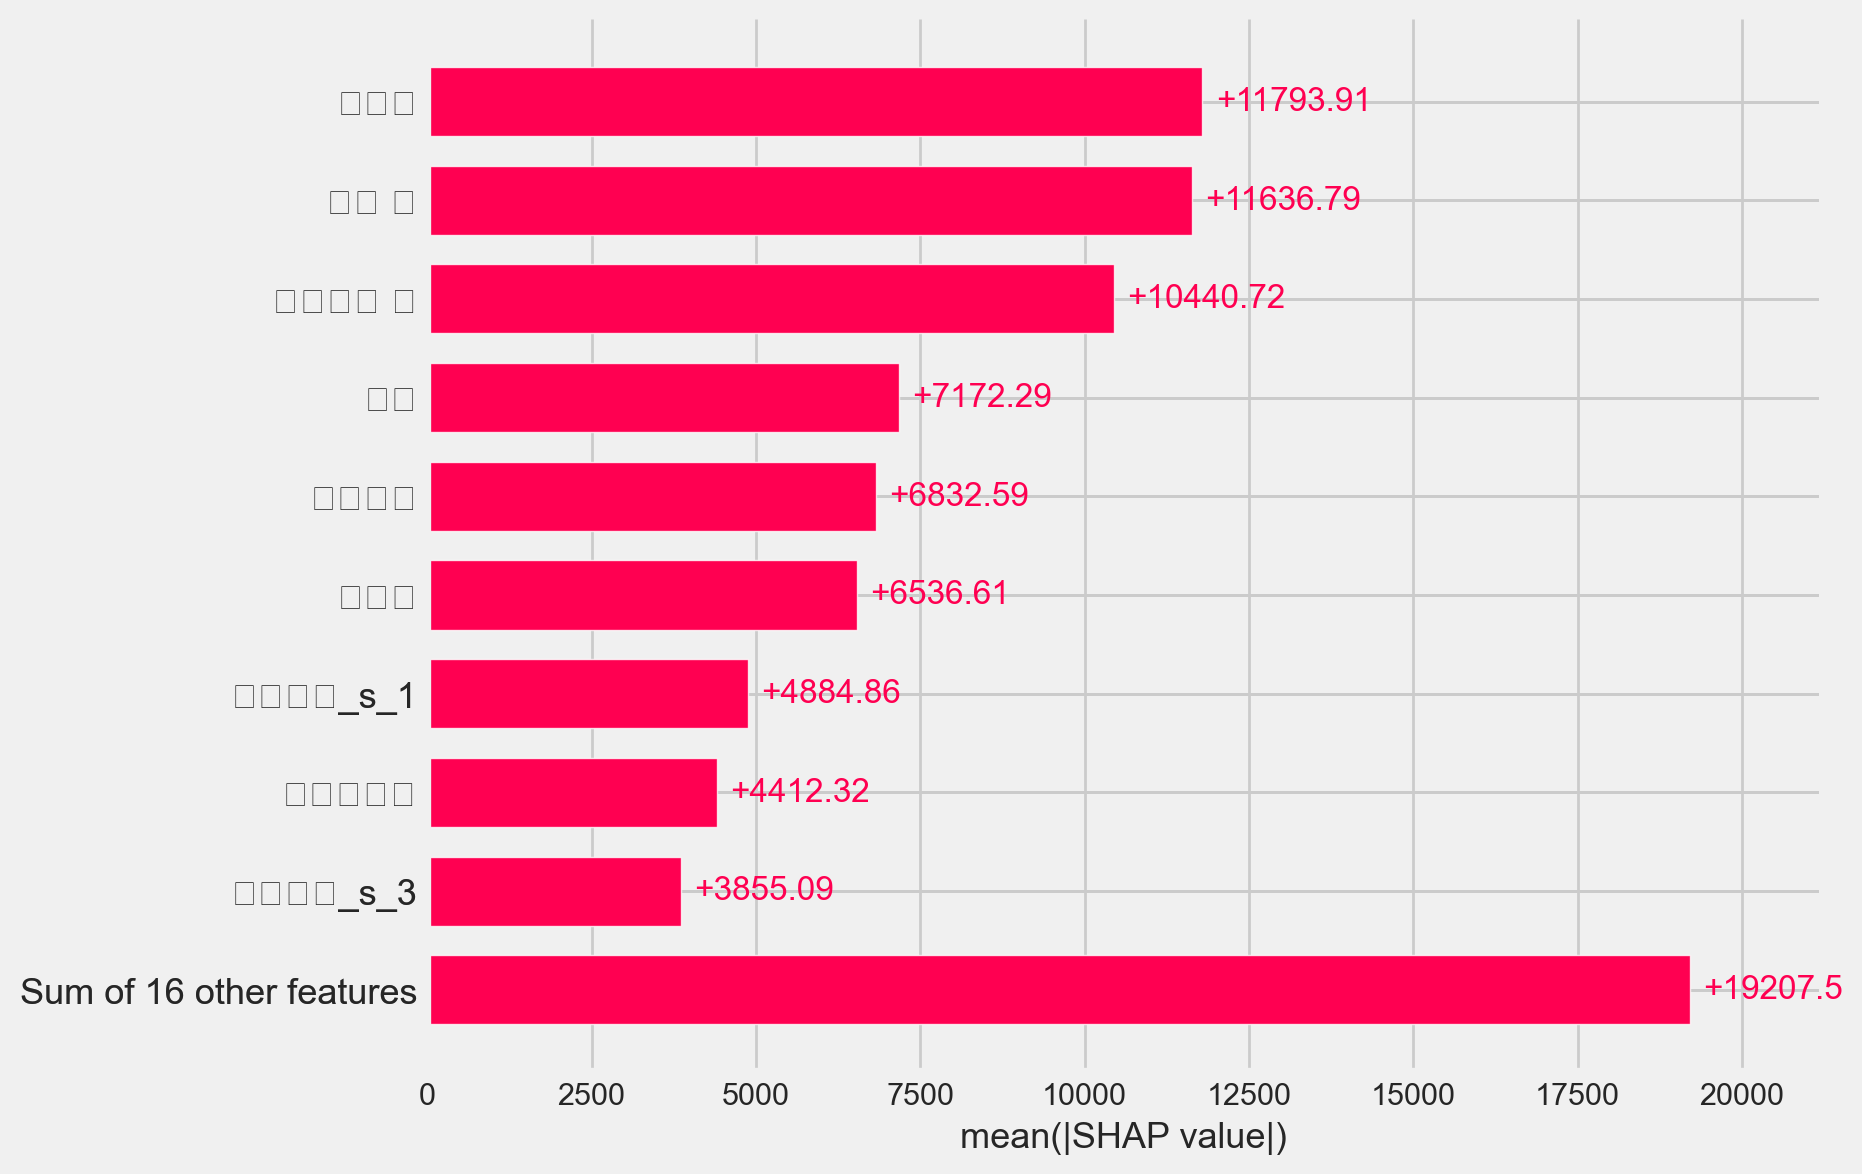

In [158]:
shap.plots.bar(shap_values)

In [159]:
# 변수별 가중치 추출
mean_absolute_shap_values = np.mean(np.abs(shap_values.values), axis=0)
variable_weights = pd.DataFrame(list(zip(X_tr_sd.columns, mean_absolute_shap_values)),
                                columns=['Variable', 'Weight'])
variable_weights = variable_weights.sort_values(by='Weight', ascending=False)

print(variable_weights)

       Variable        Weight
12          사업체  11793.906890
24         카페 수  11636.793656
21       지하철역 수  10440.717940
7            연식   7172.292559
11         기준금리   6832.590733
3           재건축   6536.610096
0      전용면적_s_1   4884.855306
15        피보험자수   4412.319637
4      전용면적_s_3   3855.092533
19       부동산 매매   3506.119537
13          학교수   2832.036844
18          총전출   2271.441189
17         병원 수   2108.823916
16       대형마트 수   1847.883952
20      월평균소득금액   1506.225347
14          총전입   1349.583179
10          공원수   1114.012085
9         부동산정책    922.135339
22            층    594.027397
8         백화점 수    490.094588
23        공원_거리    469.610628
2      전용면적_s_4    112.574875
1      전용면적_s_2     46.258725
6   법정동_Encoded     36.603781
5      전용면적_s_0      0.073303


# 6. Save File

In [43]:
from joblib import dump

In [44]:
dump(modelV0, './dev/github/mlops/djangoMLDeployment/savedModels/linear_regression_v0.joblib')

['./dev/github/mlops/djangoMLDeployment/savedModels/linear_regression_v0.joblib']

In [45]:
dump(modelV1, './dev/github/mlops/djangoMLDeployment/savedModels/Gradient_Boosting_v0.joblib')

['./dev/github/mlops/djangoMLDeployment/savedModels/Gradient_Boosting_v0.joblib']

In [ ]:
dump(modelV2, './dev/github/mlops/djangoMLDeployment/savedModels/CatBoost_v0.joblib')

In [ ]:
dump(modelV3, './dev/github/mlops/djangoMLDeployment/savedModels/XGBoost_v0.joblib')

In [ ]:
dump(modelV4, './dev/github/mlops/djangoMLDeployment/savedModels/SVR_v0.joblib')